## Naturalness Evaluation End-to-End prototype - Analysis


#### Imports

In [1]:
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import json
from collections import defaultdict
import src.util.load_consolidated_results as lcr

#### Configurations

In [2]:
config_dict = {
    'annotation_dir': './data/nl-to-sql_performance_annotations/',
    'models': [
        'gemini-1.5-pro-latest', 
        'gpt-4-0125-preview', 
        'gpt-4o',
        'gpt-3.5-turbo', 
        # 'code-bison-32k', 
        # 'code-llama-7b', 
        # 'code-llama-34b'
        'Phind-CodeLlama-34B-v2',
        'DINSQL',
        'CodeS'
        ],
    'model_label_filter': [
        # 'code-bison-32k', 
        'gemini-1.5-pro', 
        'Phind-CodeLlama-34B-v2',
        # 'code-llama-34b', 
        # 'code-llama-7b', 
        'gpt-3.5', 
        # 'gpt-4-turbo',
        'gpt-4o',
        'DINSQL',
        'CodeS'
    ],
    'database': 'all', #Database name or 'all'
    'native_only': True,
    'exclude_spider': True
}
td_dict = {True: 1, False: 0}
nat_cat_dict = {'NATIVE': 0, 'N1': 1, 'N2': 2, 'N3': 3, 'N4': 4}
# cat_label_dict = {'N1': 'Most', 'N2': 'Medium', 'N3': 'Least', 'NATIVE': 'Native', 'combined': 'Combined'}
cat_label_dict = {
    'N1': 'Regular', 
    'N2': 'Low', 
    'N3': 'Least', 
    'N4': 'Regular-Improved',
    'NATIVE': 'Native Schema', 
    'combined': 'Combined'}
model_markers = ['.', '+', '*', 'v', 'x', 'o', "|"][:len(config_dict['model_label_filter'])]
sns.set_theme(style="whitegrid")

#### Data Loading

In [3]:
loader = lcr.ConsolidatedResultsLoader()
annotation_df = loader.get_joined_dataframes()
naturalness_lookup_df = pd.read_excel('./data/gold-data/identifier-scores-evaluated-5-9-2024.xlsx')
# set to uppder case
naturalness_lookup_df['IDENTIFIER'] = naturalness_lookup_df['IDENTIFIER'].apply(lambda x: x.upper())
naturalness_lookup_df.set_index('IDENTIFIER', inplace=True)

In [4]:
annotation_df.model.unique()

array(['gemini-1.5-pro', 'gpt-3.5', 'DINSQL', 'code-llama-7b',
       'code-llama-34b', 'Phind-CodeLlama-34B-v2', 'CodeS',
       'code-bison-32k', 'gpt-4o', 'gpt-4-turbo'], dtype=object)

In [5]:
annotation_df = annotation_df.query(f"model in {config_dict['model_label_filter']}")
annotation_df.model.unique()

array(['gemini-1.5-pro', 'gpt-3.5', 'DINSQL', 'Phind-CodeLlama-34B-v2',
       'CodeS', 'gpt-4o'], dtype=object)

In [6]:
annotation_df["model_abbreviated"] = annotation_df.model.apply(
    lambda x: {
        'code-bison-32k': 'Bsn-ZS', 
        'gemini-1.5-pro': 'Gem-1.5-ZS', 
        'Phind-CodeLlama-34B-v2': 'Ph-CdLlm2-ZS',
        'code-llama-34b': 'CdLlm2-34b-ZS', 
        'code-llama-7b': 'CdLlm2-7b-ZS', 
        'gpt-3.5': 'GPT-3.5-ZS', 
        'gpt-4-turbo': 'GPT-4T-ZS',
        'gpt-4o': 'GPT-4o-ZS',
        'DINSQL': 'DINSQL',
        'CodeS': 'CodeS'
    }[x])

annotation_df["model_prompt"] = annotation_df.model.apply(
    lambda x: {
        'code-bison-32k': 'Bison-ZS', 
        'gemini-1.5-pro': 'Gemini-1.5-ZS', 
        'Phind-CodeLlama-34B-v2': 'Phind-CodeLlama2-ZS',
        'code-llama-34b': 'CodeLlama2-34b-ZS', 
        'code-llama-7b': 'CodeLlama2-7b-ZS', 
        'gpt-3.5': 'GPT-3.5-ZS', 
        'gpt-4-turbo': 'GPT-4T-ZS',
        'gpt-4o': 'GPT-4o-ZS',
        'DINSQL': 'GPT-4o-DINSQL',
        'CodeS': 'Codes-FT'
    }[x])


In [7]:
annotation_df.model.unique()

array(['gemini-1.5-pro', 'gpt-3.5', 'DINSQL', 'Phind-CodeLlama-34B-v2',
       'CodeS', 'gpt-4o'], dtype=object)

In [8]:
annotation_df.naturalness.unique()

array(['N1', 'N3', 'NATIVE', 'N2'], dtype=object)

### Data Processing

Make database label column

In [9]:
database_label_dict = {
    "ASIS_20161108_HerpInv_Database": "ASIS",
    "ATBI": "ATBI",
    "CratersWildlifeObservations": "CWO",
    "KlamathInvasiveSpecies": "KIS",
    "NTSB": "NTSB",
    "NYSED_SRC2022": "NYSED",
    "NorthernPlainsFireManagement": "NPFM",
    "PacificIslandLandbirds": "PILB",
    "SBODemoUS-Banking": "SBOD",
    'SBODemoUS-Business Partners': "SBOD", 
    'SBODemoUS-Finance': "SBOD",
    'SBODemoUS-General': "SBOD", 
    'SBODemoUS-Human Resources': "SBOD",
    'SBODemoUS-Inventory and Production': "SBOD", 
    'SBODemoUS-Reports': "SBOD",
    'SBODemoUS-Sales Opportunities': "SBOD", 
    'SBODemoUS-Service': "SBOD",
    "spider": "Spider",
}
    

In [10]:
annotation_df['database'] = annotation_df['database'].apply(lambda x: "spider" if "spider" in x else x)
annotation_df['Database Label'] = annotation_df['database'].apply(lambda x: database_label_dict[x])
if config_dict["exclude_spider"]:
    annotation_df = annotation_df.query("database != 'spider'")
annotation_df['Database Label'].unique()

array(['SBOD', 'NTSB', 'PILB', 'KIS', 'ATBI', 'ASIS', 'NYSED', 'NPFM',
       'CWO'], dtype=object)

In [11]:
annotation_df['naturalness_label'] = annotation_df.apply(
    lambda row: cat_label_dict[row.naturalness],
    axis=1
)

In [12]:
annotation_df["mean_token_char_ratio_rounded"] = annotation_df["mean_token_char_ratio"].round(2)

In [13]:
annotation_df['schema_modified'] = annotation_df.apply(lambda row: "native" if row.naturalness == 'NATIVE' else 'modified', axis=1)

In [14]:
annotation_df['exclude_from_linking'] = annotation_df.apply(
    lambda row: True if row.f1 == 0 and row.extra_tables == 'set()' and row.extra_columns == 'set()' else False,
    axis=1
)

In [15]:
annotation_df['exclude_from_linking'].value_counts()

exclude_from_linking
False    11936
True       146
Name: count, dtype: int64

In [16]:
annotation_df.query('naturalness == "NATIVE"').exclude_from_linking.value_counts()

exclude_from_linking
False    2992
True       36
Name: count, dtype: int64

<Axes: >

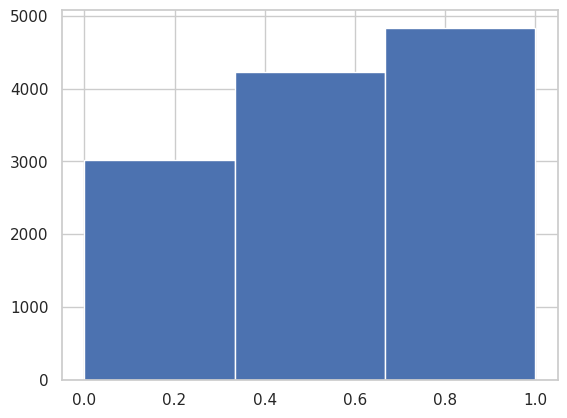

In [17]:
comb_weights={'N1': 1, 'N2': .5, 'N3': 0}

annotation_df['Qg_combined_nat'] = annotation_df.apply(
    lambda row: (
        (row.Qg_identifier_N1_pct)*comb_weights['N1'] +
        (row.Qg_identifier_N2_pct)*comb_weights['N2'] +
        (row.Qg_identifier_N3_pct)*comb_weights['N3']
        ),
    axis=1
)

annotation_df['schema_combined_nat'] = annotation_df.apply(
    lambda row: (
        (row.schema_identifier_N1_pct)*comb_weights['N1'] +
        (row.schema_identifier_N2_pct)*comb_weights['N2'] +
        (row.schema_identifier_N3_pct)*comb_weights['N3']
        ),
    axis=1
)

annotation_df.schema_combined_nat.hist(bins=3)

In [18]:
native_nat_lookup = annotation_df.query(
    "naturalness == 'NATIVE'"
    )[["Database Label", "schema_combined_nat"]].drop_duplicates().dropna(
        how="all"
        ).groupby("Database Label").mean()

annotation_df["db_native_naturalness"] = annotation_df.rename(columns={
    "Database Label": "db_label"
}).apply(
    lambda row: native_nat_lookup.loc[row.db_label]["schema_combined_nat"],
    axis=1
)
annotation_df.db_native_naturalness

0        0.488391
1        0.488391
2        0.488391
3        0.488391
4        0.488391
           ...   
28820    0.700461
28821    0.700461
28822    0.700461
28823    0.700461
28824    0.700461
Name: db_native_naturalness, Length: 12082, dtype: float64

#### Data Exploration

##### Make a pivot table of query statistics at the query level

In [19]:
import json
stats_db = []
stats_q = []
keys = []
values =  []
temp_df = annotation_df[['Database Label', 'question_number_combined_modules', 'query_stats']].drop_duplicates().dropna(how='all')
temp_df = temp_df.rename(columns={'Database Label': 'Database_Label'})
for row in temp_df.itertuples():
    q_stats = json.loads(row.query_stats.replace("'", '"'))
    for stat in q_stats:
        stats_db.append(row.Database_Label)
        stats_q.append(row.question_number_combined_modules)
        keys.append(list(stat.keys())[0])
        values.append(stat[list(stat.keys())[0]])
stats_df = pd.DataFrame({
    'Database_Label': stats_db,
    'question': stats_q,
    'stat_type': keys, 
    'stat_value': values
    }).query("stat_type != 'table' and stat_type != 'column'")
stats_df


Database_Label  question          stat_type stat_value
0              SBOD       701     select element          1
2              SBOD       701     select element          1
4              SBOD       701  table source item          1
6              SBOD       701               join          1
7              SBOD       701  table source item          1
...             ...       ...                ...        ...
8907           SBOD       810     select element          1
8908           SBOD       810     select element          1
8909           SBOD       810           function        avg
8911           SBOD       810  table source item          1
8913           SBOD       810           group by          1

[5208 rows x 4 columns]

In [20]:
pivot_df = stats_df.pivot_table(
    index=['Database_Label', 'question'],
    columns=['stat_type'],
    values=['stat_value'],
    aggfunc='count'
)
question_query_stats_df = pivot_df.fillna(0)
question_query_stats_df

stat_value                                          \
stat_type                 asterisk case composite-key-join exists function   
Database_Label question                                                      
ASIS           1               0.0  0.0                0.0    0.0      1.0   
               2               0.0  0.0                0.0    0.0      1.0   
               3               0.0  0.0                0.0    0.0      1.0   
               4               0.0  0.0                0.0    0.0      0.0   
               5               0.0  0.0                0.0    0.0      1.0   
...                            ...  ...                ...    ...      ...   
SBOD           906             0.0  0.0                0.0    0.0      1.0   
               907             0.0  0.0                0.0    0.0      0.0   
               908             0.0  0.0                0.0    0.0      0.0   
               909             0.0  0.0                0.0    0.0      1.0   
               910             0.0  0.0                0.0    0.0      0.0   

                                                                        \
stat_type               group by having join logical operator negation   
Database_Label question                                                  
ASIS           1             0.0    0.0  0.0              0.0      0.0   
               2             1.0    0.0  0.0              0.0      0.0   
               3             0.0    0.0  0.0              0.0      0.0   
               4             0.0    0.0  1.0              0.0      0.0   
               5             1.0    0.0  0.0              0.0      0.0   
...                          ...    ...  ...              ...      ...   
SBOD           906           2.0    0.0  0.0              0.0      0.0   
               907           0.0    0.0  1.0              0.0      0.0   
               908           0.0    0.0  0.0              0.0      0.0   
               909           1.0    0.0  1.0              0.0      0.0   
               910           0.0    0.0  0.0              1.0      0.0   

                                                                         \
stat_type               non ansi join order by predicate select element   
Database_Label question                                                   
ASIS           1                  0.0      0.0       1.0            1.0   
               2                  0.0      0.0       0.0            2.0   
               3                  0.0      0.0       0.0            1.0   
               4                  0.0      0.0       1.0            1.0   
               5                  0.0      0.0       0.0            2.0   
...                               ...      ...       ...            ...   
SBOD           906                0.0      0.0       1.0            3.0   
               907                0.0      0.0       2.0            3.0   
               908                0.0      0.0       1.0            3.0   
               909                0.0      0.0       1.0            2.0   
               910                0.0      0.0       2.0            1.0   

                                                                     
stat_type               subquery table source item top clause where  
Database_Label question                                              
ASIS           1             0.0               1.0        0.0   1.0  
               2             0.0               1.0        0.0   0.0  
               3             0.0               1.0        0.0   0.0  
               4             0.0               2.0        0.0   0.0  
               5             0.0               1.0        0.0   0.0  
...                          ...               ...        ...   ...  
SBOD           906           0.0               1.0        0.0   1.0  
               907           0.0               2.0        0.0   1.0  
               908           0.0               1.0        0.0   1.0  
   

##### Make a pivot table of query statistics at the database level.

In [21]:
db_query_stats_df = pivot_df.reset_index().groupby('Database_Label').count()
# db_query_stats_df[['question']].merge(db_query_stats_df['stat_value'])
query_stats_table = db_query_stats_df[['question']].droplevel(1, axis=1).join(
    db_query_stats_df['stat_value']
).reset_index()[[
    'Database_Label',
    'question', 
    'top clause',
    'function',
    'join',
    'composite-key-join',
    'exists',
    'subquery',
    'where',
    'negation',
    'group by',
    'order by',
    'having', 
    ]].rename(columns={
        'Database_Label': 'Database',
        'question': 'Qs',
        'top clause': 'Top',
        'function': 'Function',
        'join': 'Join',
        'composite-key-join': 'CK Join',
        'exists': 'Exists',
        'subquery': 'Subquery',
        'where': 'Where',
        'negation': 'Negation',
        'group by': 'Group By',
        'order by': 'Order By',
        'having': 'Having'
    })
query_stats_table.to_latex('./figure_output/query_stats.tex', index=False)

/tmp/ipykernel_38543/499371879.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  db_query_stats_df = pivot_df.reset_index().groupby('Database_Label').count()


Show the database schema table and column counts

In [22]:
schema_desc_cols = [
    'database', 
    'schema_tab_count',
    'schema_tab_N1',
    'schema_tab_N2',
    'schema_tab_N3',
    'schema_col_count',
    'schema_col_N1',
    'schema_col_N2',
    'schema_col_N3',
    ]
annotation_df.query("naturalness == 'NATIVE'")[schema_desc_cols].groupby(schema_desc_cols).count()

Empty DataFrame
Columns: []
Index: [(ASIS_20161108_HerpInv_Database, 36, 1, 35, 0, 245, 181, 34, 30), (ATBI, 28, 1, 27, 0, 192, 118, 43, 31), (CratersWildlifeObservations, 13, 11, 2, 0, 71, 54, 9, 8), (KlamathInvasiveSpecies, 18, 1, 17, 0, 157, 117, 24, 16), (NTSB, 40, 18, 17, 5, 1161, 489, 390, 282), (NYSED_SRC2022, 27, 11, 11, 5, 423, 187, 202, 34), (NorthernPlainsFireManagement, 27, 1, 26, 0, 190, 117, 42, 31), (PacificIslandLandbirds, 21, 2, 18, 1, 196, 136, 32, 28), (SBODemoUS-Banking, 40, 0, 0, 40, 913, 177, 552, 162), (SBODemoUS-Banking, 2588, 12, 3, 2573, 90477, 20522, 49195, 20757), (SBODemoUS-Business Partners, 40, 0, 0, 40, 675, 196, 359, 83), (SBODemoUS-Business Partners, 2588, 12, 3, 2573, 90477, 20522, 49195, 20757), (SBODemoUS-Finance, 61, 2, 0, 59, 995, 219, 536, 220), (SBODemoUS-Finance, 2588, 12, 3, 2573, 90477, 20522, 49195, 20757), (SBODemoUS-General, 71, 0, 0, 71, 552, 173, 257, 75), (SBODemoUS-General, 2588, 12, 3, 2573, 90477, 20522, 49195, 20757), (SBODemoUS-Human Resources, 28, 0, 0, 28, 200, 64, 97, 10), (SBODemoUS-Human Resources, 2588, 12, 3, 2573, 90477, 20522, 49195, 20757), (SBODemoUS-Inventory and Production, 65, 0, 0, 65, 1061, 210, 584, 226), (SBODemoUS-Inventory and Production, 2588, 12, 3, 2573, 90477, 20522, 49195, 20757), (SBODemoUS-Reports, 40, 0, 0, 40, 643, 199, 281, 147), (SBODemoUS-Reports, 2588, 12, 3, 2573, 90477, 20522, 49195, 20757), (SBODemoUS-Sales Opportunities, 20, 0, 0, 20, 112, 33, 64, 8), (SBODemoUS-Sales Opportunities, 2588, 12, 3, 2573, 90477, 20522, 49195, 20757), (SBODemoUS-Service, 40, 0, 1, 39, 379, 130, 177, 18), (SBODemoUS-Service, 2588, 12, 3, 2573, 90477, 20522, 49195, 20757)]

#### Show the naturalness of each schema

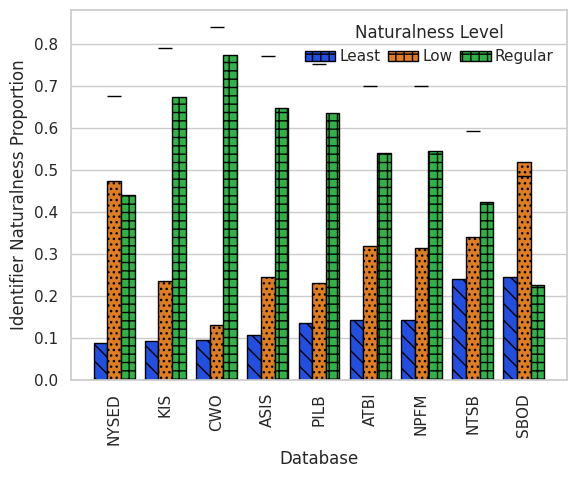

In [23]:

nat_plot_df = annotation_df[annotation_df['naturalness'] == 'NATIVE'].copy().sort_values(
    by='naturalness_order',
    ascending=False
    )

nat_plot_df = nat_plot_df[[
    'Database Label', 
    'schema_identifier_N1_pct', 'schema_identifier_N2_pct', 'schema_identifier_N3_pct',
    'schema_combined_nat'
    ]].groupby('Database Label').mean().reset_index()

nat_plot_df = nat_plot_df.melt(
    id_vars = ['Database Label'],
    value_vars = [
        'schema_identifier_N1_pct', 
        'schema_identifier_N2_pct', 
        'schema_identifier_N3_pct',
        'schema_combined_nat'
    ]
)

nat_plot_df['db_id_type'] = nat_plot_df.apply(
    lambda row: row.variable.split('_')[2],
    axis=1
)

nat_plot_df['variable'] = nat_plot_df.apply(
    lambda row: row.variable.split('_')[2] if row.variable != 'schema_combined_nat' else 'combined',
    axis=1
)

nat_plot_df.rename(columns={'variable': 'naturalness'}, inplace=True)
nat_plot_df = nat_plot_df.sort_values(by=['naturalness'])
nat_plot_df['Naturalness Level'] = nat_plot_df.naturalness.apply(lambda x: cat_label_dict[x])
nat_plot_df.sort_values(by=['Naturalness Level', 'value'], inplace=True)
f, ax = plt.subplots()
# for row in nat_plot_df.sort_values(by=['Naturalness Level', 'value']).query("naturalness == 'combined'")[['Database Label', 'value']].itertuples():
#     ax.plot(row[1], row.value, marker='*', markersize=10, color='black')
plt.xticks(rotation=90)
hatches = ['\\\\', '...', '++']
bar = sns.barplot(
    data=nat_plot_df.query("naturalness != 'combined'"),
    y='value',
    x='Database Label',
    hue='Naturalness Level',
    orient='v',
    edgecolor='black',
    palette='bright',
)
for i, thisbar in enumerate(bar.patches):
    if i < 9:
        thisbar.set_hatch(hatches[0])
    elif i < 18:
        thisbar.set_hatch(hatches[1])
    else:
        thisbar.set_hatch(hatches[2])
for item in ax.get_xticklabels():
    ax.plot(
        item.get_position()[0], 
        nat_plot_df.query("`Database Label` == @item.get_text() and naturalness == 'combined'").value.values[0], 
        marker='_', 
        markersize=10, 
        color='black'
        )
ax.legend(
    title='Naturalness Level', 
    loc='upper right', 
    ncol=4, 
    frameon=False, 
    columnspacing=.5, 
    handletextpad=0.25,
    )

ax.set_xlabel('Database')
ax.set_ylabel('Identifier Naturalness Proportion')

bar.figure.savefig('./figure_output/naturalness_by_db.pdf', bbox_inches='tight', dpi=300)



#### Trellis of scatter plots relating query naturalness levels to schema linking scores over native databases

In [24]:
annotation_df.model.unique()

array(['gemini-1.5-pro', 'gpt-3.5', 'DINSQL', 'Phind-CodeLlama-34B-v2',
       'CodeS', 'gpt-4o'], dtype=object)

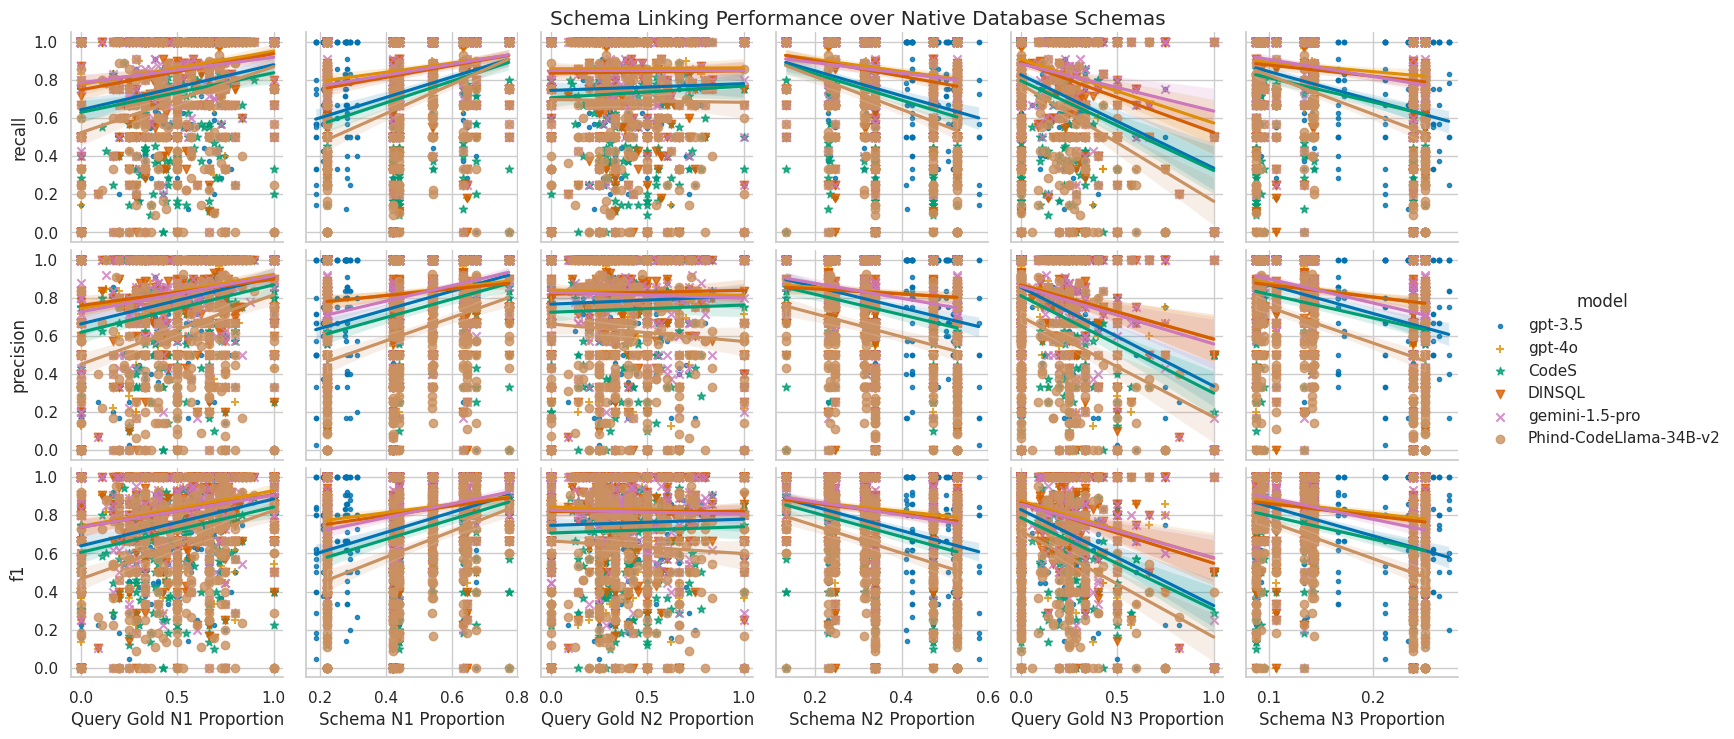

In [25]:
plot = sns.pairplot(
    annotation_df.rename(columns={
        'Qg_identifier_N1_pct': 'Query Gold N1 Proportion',
        'schema_identifier_N1_pct': 'Schema N1 Proportion',
        'Qg_identifier_N2_pct': 'Query Gold N2 Proportion',
        'schema_identifier_N2_pct': 'Schema N2 Proportion',
        'Qg_identifier_N3_pct': 'Query Gold N3 Proportion',
        'schema_identifier_N3_pct': 'Schema N3 Proportion',
    }).query("naturalness == 'NATIVE' and exclude_from_linking == False"), 
    kind="reg",
    x_vars=[
        'Query Gold N1 Proportion',
        'Schema N1 Proportion',
        'Query Gold N2 Proportion',
        'Schema N2 Proportion',
        'Query Gold N3 Proportion',
        'Schema N3 Proportion',
        ], 
    y_vars=['recall', 'precision', 'f1'],
    hue='model',
    palette='colorblind',
    markers=model_markers
    ) 
plot.figure.suptitle('Schema Linking Performance over Native Database Schemas')
plot.figure.subplots_adjust(top=.95)
plot.savefig('./figure_output/schema-linking-performance-over-native-database-schemas.pdf', dpi=300)

#### Trellis of scatter plots relating query naturalness levels to schema linking scores over modified databases

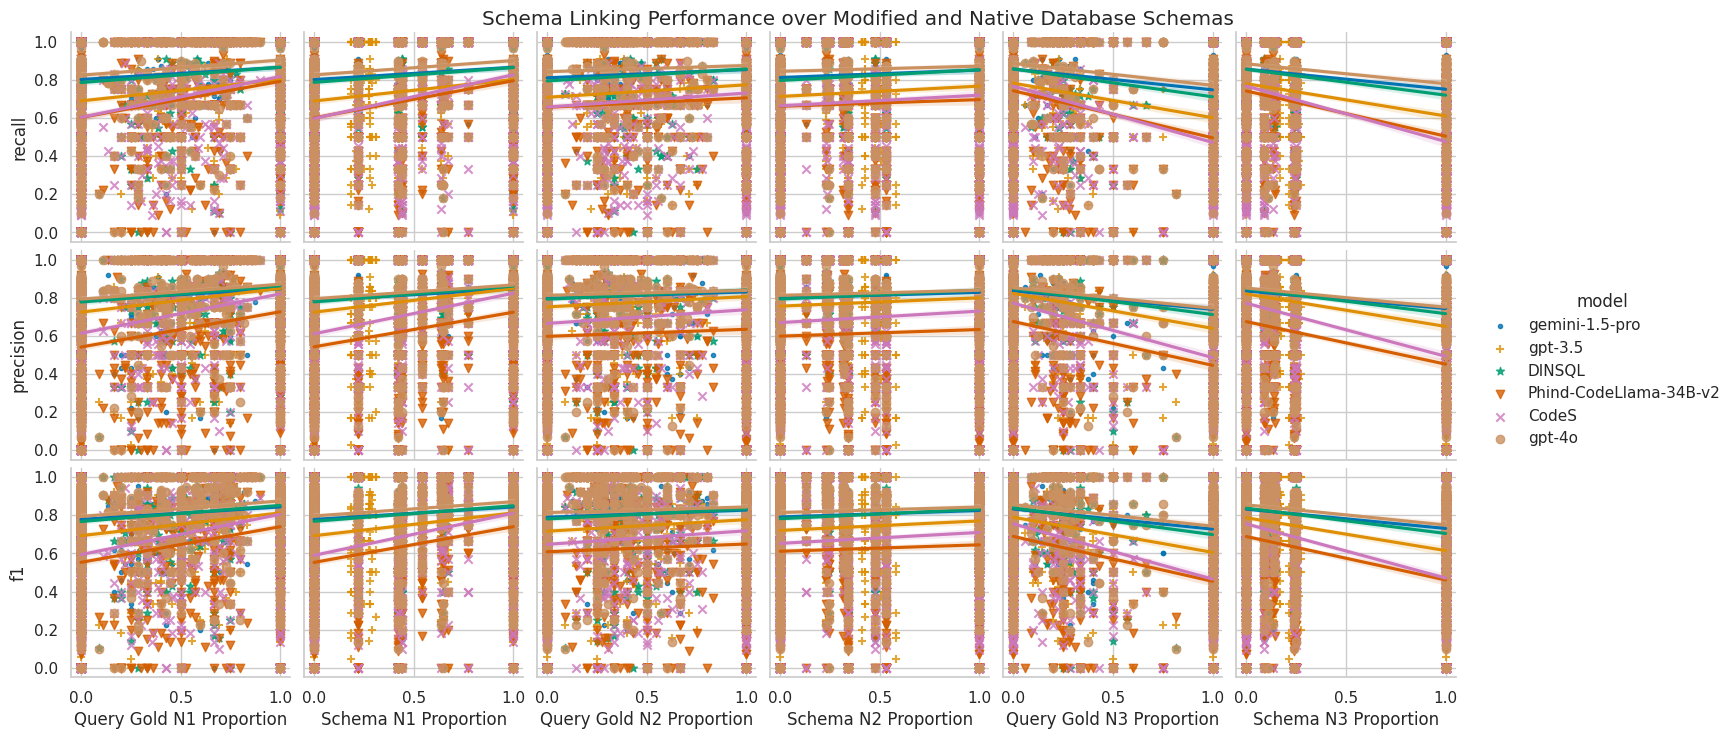

In [26]:
plot = sns.pairplot(
    annotation_df.rename(columns={
        'Qg_identifier_N1_pct': 'Query Gold N1 Proportion',
        'schema_identifier_N1_pct': 'Schema N1 Proportion',
        'Qg_identifier_N2_pct': 'Query Gold N2 Proportion',
        'schema_identifier_N2_pct': 'Schema N2 Proportion',
        'Qg_identifier_N3_pct': 'Query Gold N3 Proportion',
        'schema_identifier_N3_pct': 'Schema N3 Proportion',
    }).query("exclude_from_linking == False"), 
    kind="reg",
    x_vars=[
        'Query Gold N1 Proportion',
        'Schema N1 Proportion',
        'Query Gold N2 Proportion',
        'Schema N2 Proportion',
        'Query Gold N3 Proportion',
        'Schema N3 Proportion',
        ], 
    y_vars=['recall', 'precision', 'f1'],
    hue='model',
    palette='colorblind',
    markers=model_markers
    ) 
plot.figure.suptitle('Schema Linking Performance over Modified and Native Database Schemas')
plot.figure.subplots_adjust(top=.95)
plot.savefig('./figure_output/schema-linking-performance-over-modified-database-schemas.pdf', dpi=300)

The above chart gives us a visual understanding of the possible correlations between varying query naturalness levels and schema linking performance measured with recall, precision, and f1 score.


In [27]:
y = [
    'result_set_match',
    'string_match',
    'recall',
    'precision',
    'f1',
    'manual_match',
    'has_group_by_errors',
    'has_invalid_SQL_errors',
    'has_nested_errors',
    'has_other_errors',
    'has_schema_linking_errors',
    'word_level_mean_max_cosine_similarity',
    'sentence_level_cosine_similarity'
]
x = [
    'schema_tab_count',
    'schema_col_count',
    'Qg_col_N1_pct',
    'Qg_col_N2_pct',
    'Qg_col_N3_pct',
    'Qg_tab_N1_pct',
    'Qg_tab_N2_pct',
    'Qg_tab_N3_pct',
    'schema_combined_nat',
    'Qg_combined_nat',
    'schema_col_N1_pct',
    'schema_col_N2_pct',
    'schema_col_N3_pct',
    'schema_tab_N1_pct',
    'schema_tab_N2_pct',
    'schema_tab_N3_pct',
    'prompt_token_count',
    'mean_token_char_ratio',
    'word_level_mean_max_cosine_similarity',
    'sentence_level_cosine_similarity'
]

##### Combined naturalness x linking measurements

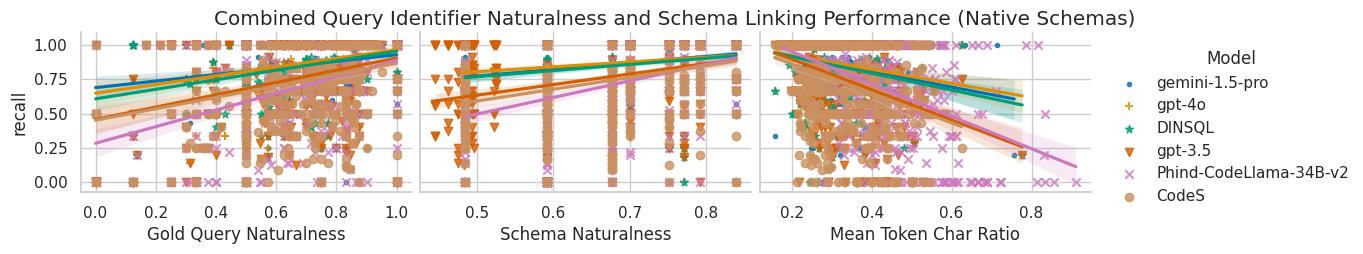

In [28]:
fig = sns.pairplot(
    annotation_df.rename(columns={
        'Qg_combined_nat': 'Gold Query Naturalness',
        'schema_combined_nat': 'Schema Naturalness',
        'mean_token_char_ratio': 'Mean Token Char Ratio'
    }).sort_values(
        by='model_order',
        ascending=True
    ).query("naturalness == 'NATIVE' and exclude_from_linking == False"), 
    kind="reg",
    x_vars=['Gold Query Naturalness', 'Schema Naturalness', 'Mean Token Char Ratio'], 
    # y_vars=['recall', 'precision', 'f1'],
    y_vars=['recall'],
    hue='model',
    palette='colorblind',
    aspect=1.5,
    markers=model_markers
    )
fig._legend.set_title('Model')
fig.figure.suptitle('Combined Query Identifier Naturalness and Schema Linking Performance (Native Schemas)')
fig.figure.subplots_adjust(top=.89)
fig.savefig('./figure_output/combined-query-identifier-naturalness-and-schema-linking-performance-native.pdf', dpi=300)

#### Scatterplot and regression on original schemas

<Figure size 640x480 with 0 Axes>

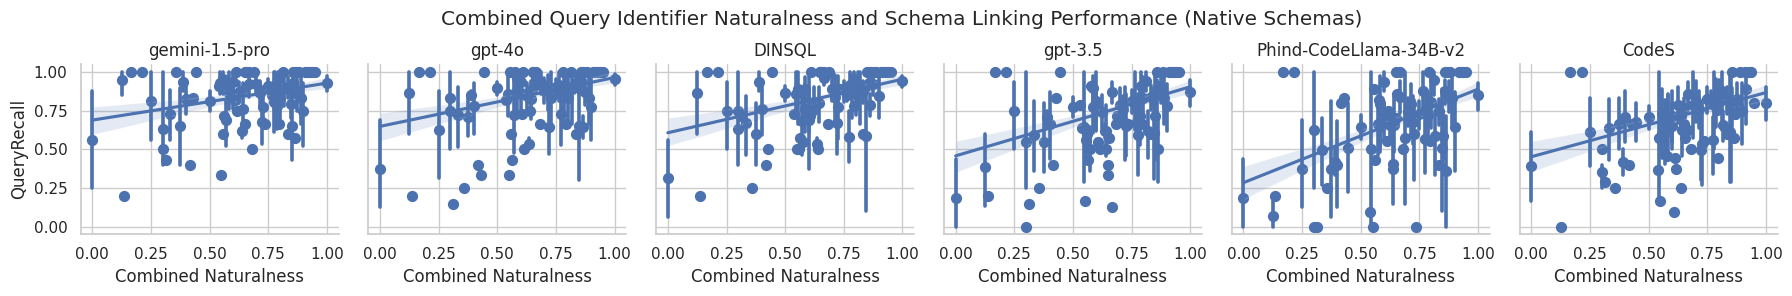

<Figure size 640x480 with 0 Axes>

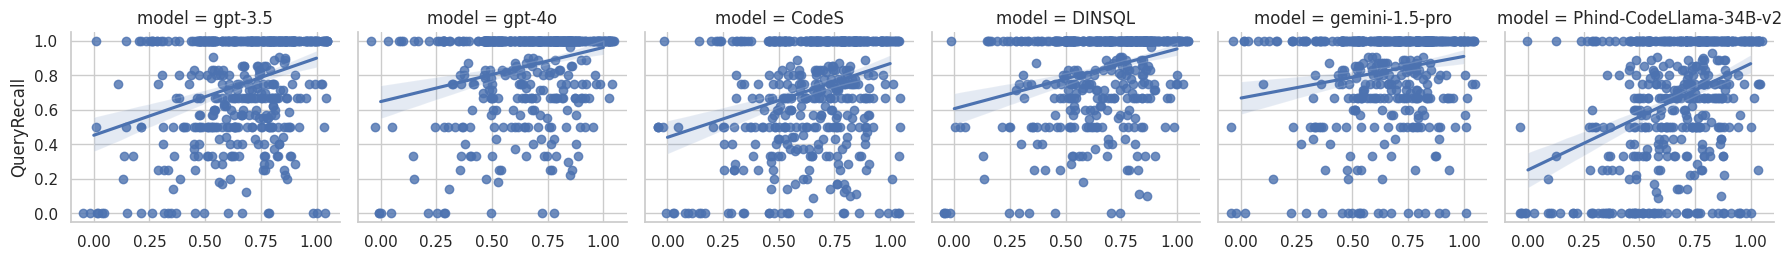

In [29]:
plt.figure()
tau_values = ["0.124", "0.216", "0.201", "0.254"]
p_values = ["0.001", "0.001", "0.001", "0.001"]
g = sns.FacetGrid(
    annotation_df.rename(
        columns={'Qg_combined_nat': 'Combined Naturalness'}
        ).sort_values(
            by='model_order',
        ).query("naturalness == 'NATIVE' and exclude_from_linking == False"),
    col='model',
    palette='colorblind',
    aspect=1,
    # markers=model_markers
)
g.map(
    sns.regplot, 
    'Combined Naturalness', 
    'recall',
    x_jitter=.05,
    x_estimator=np.mean,
    ci=95,
    fit_reg=True,
    # kind="reg", 
    # hue='model'
    )
g.set_axis_labels('Combined Naturalness', 'QueryRecall')
# for ax in g.axes.flat[1:]:
#     ax.set_xlabel('')

for ix, ax in enumerate(g.axes.flat):
    ax.set_title(
        str(ax.get_title()).replace("model = ", "") 
        # + f", τ = {tau_values[ix]}"
        )
g.figure.suptitle('Combined Query Identifier Naturalness and Schema Linking Performance (Native Schemas)')
g.figure.subplots_adjust(top=.80)
g.figure.xlabel='Combined Naturalness'
g.savefig('./figure_output/combined-query-identifier-naturalness-and-recall-performance-native-model-facet.pdf', dpi=300)
plt.figure()
g = sns.FacetGrid(
    annotation_df.rename(columns={'Qg_combined_nat': 'Combined Naturalness'}).query("naturalness == 'NATIVE'"),
    col='model',
    palette='colorblind',
    aspect=1,
    # markers=model_markers
)
g.map(
    sns.regplot, 
    'Combined Naturalness', 
    'recall',
    x_jitter=.05,
    ci=95,
    fit_reg=True,
    # kind="reg", 
    # hue='model'
    )
g.set_axis_labels('Combined Naturalness', 'QueryRecall')
for ax in g.axes.flat:
    ax.set_xlabel('')

Mean Token-Char Ratio

<Figure size 640x480 with 0 Axes>

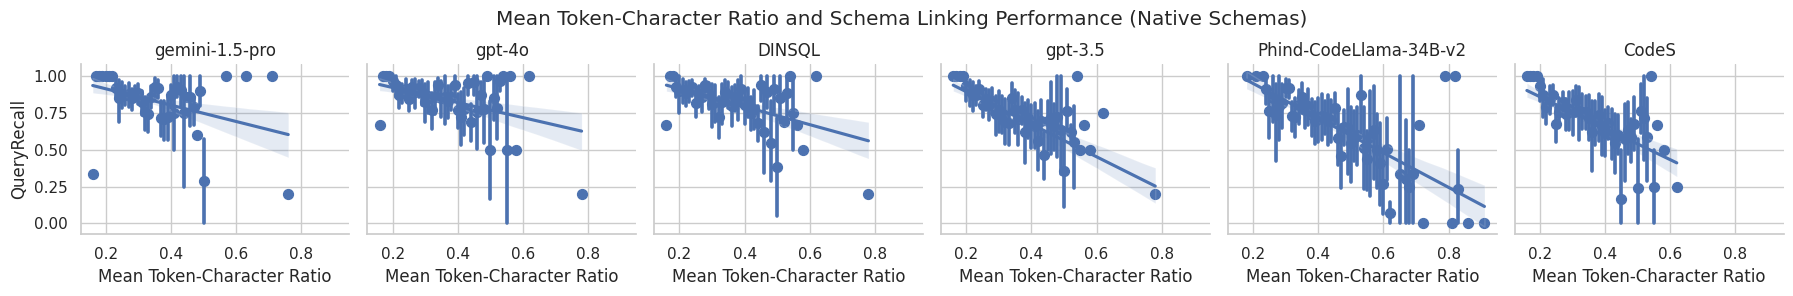

In [30]:
plt.figure()
tau_values = ["-0.139", "-0.167", "-0.188", "-0.272"]
g = sns.FacetGrid(
    annotation_df.rename(
        columns={'mean_token_char_ratio_rounded': 'Mean Token-Character Ratio'}
        ).sort_values(
            by='model_order',
        ).query("exclude_from_linking == False and naturalness == 'NATIVE'"),
    col='model',
    palette='colorblind',
    aspect=1,
)
g.map(
    sns.regplot, 
    'Mean Token-Character Ratio', 
    'recall',
    x_jitter=.05,
    x_estimator=np.mean,
    ci=95,
    fit_reg=True,
    )
g.set_axis_labels('Mean Token-Character Ratio', 'QueryRecall')
for ix, ax in enumerate(g.axes.flat):
    ax.set_title(
        str(ax.get_title()).replace("model = ", "") 
        # + f", τ = {tau_values[ix]}"
        )
g.figure.suptitle('Mean Token-Character Ratio and Schema Linking Performance (Native Schemas)')
g.figure.subplots_adjust(top=.80)
g.figure.xlabel='Combined Naturalness'
g.savefig('./figure_output/mean-token-char-ratio-and-recall-performance-nativeschema-model-facet.pdf', dpi=300)


In [31]:
annotation_df.extra_columns.unique()

array(['set()', "{'ABSENTRY'}", "{'CATNAME', 'CATEGORYID', 'MODULE'}",
       ..., "{'YCOORD'}",
       "{'TREECOND_TEXT', 'LOCATION_ID', 'EVENT_ID', 'TREECOND_NUM'}",
       "{'TOTALCOUNT', 'OVERSTORY_ID'}"], dtype=object)

#### Scatterplot and regression again for each naturalness level

##### Single row, all databases combined, model facets

<Figure size 640x480 with 0 Axes>

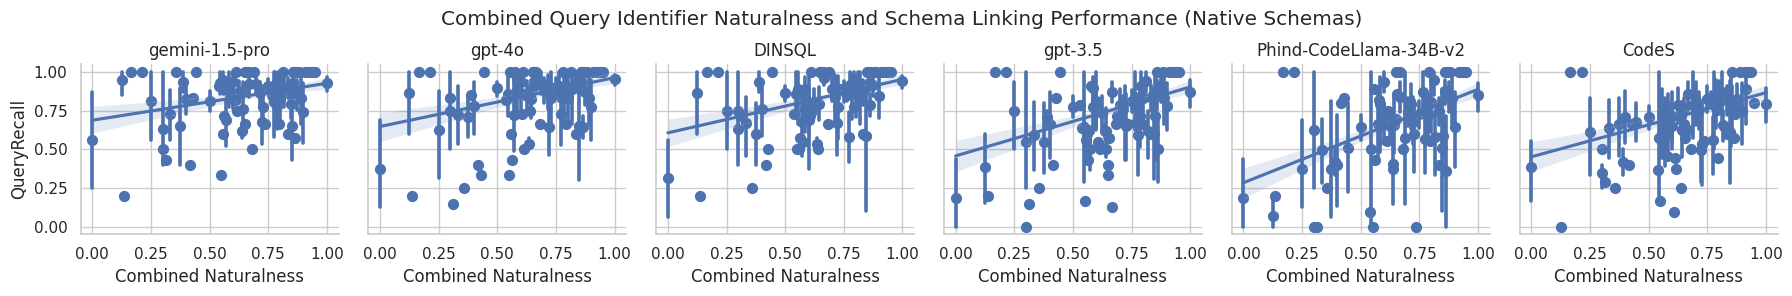

<Figure size 640x480 with 0 Axes>

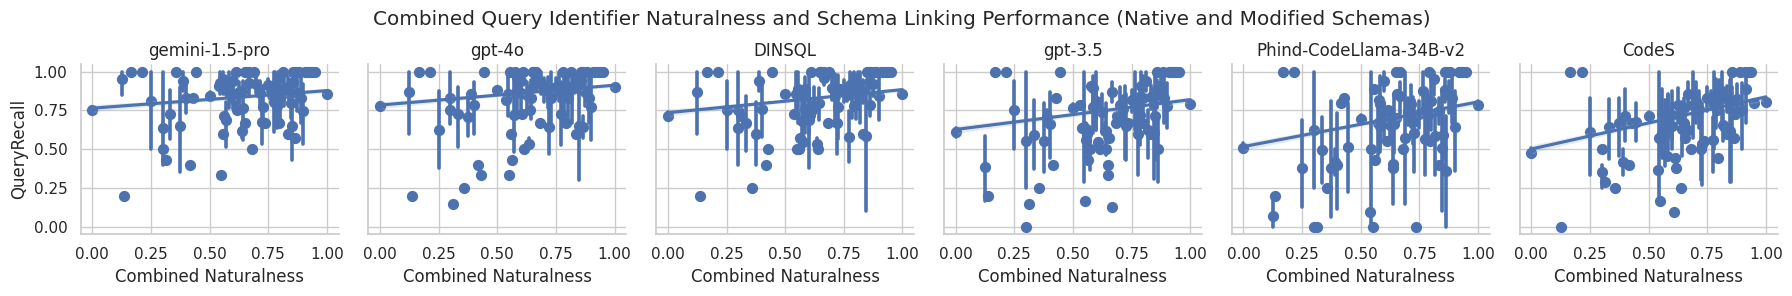

<Figure size 640x480 with 0 Axes>

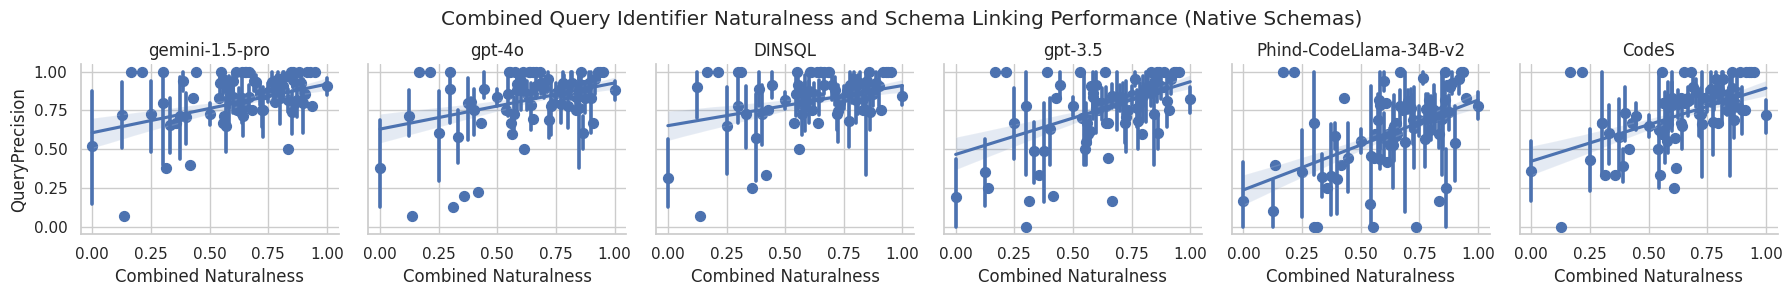

<Figure size 640x480 with 0 Axes>

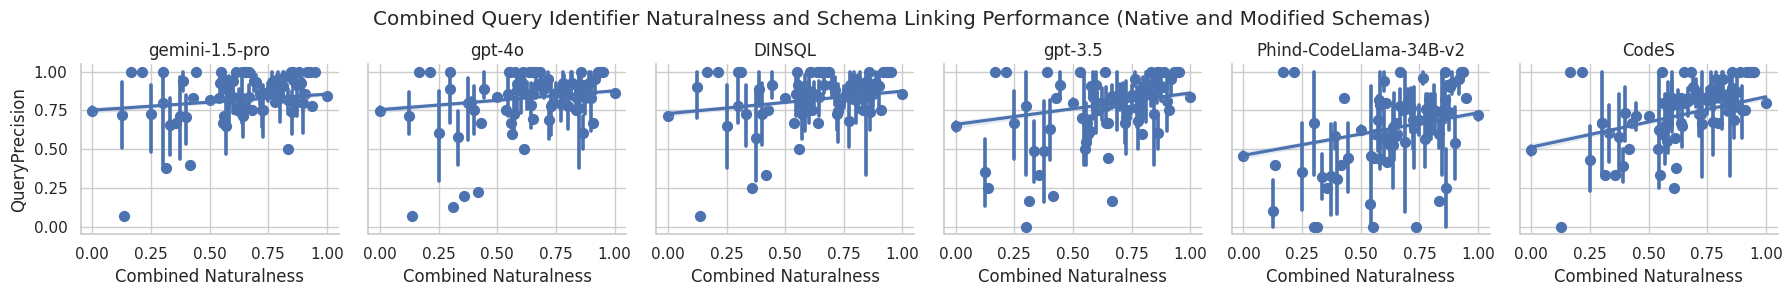

<Figure size 640x480 with 0 Axes>

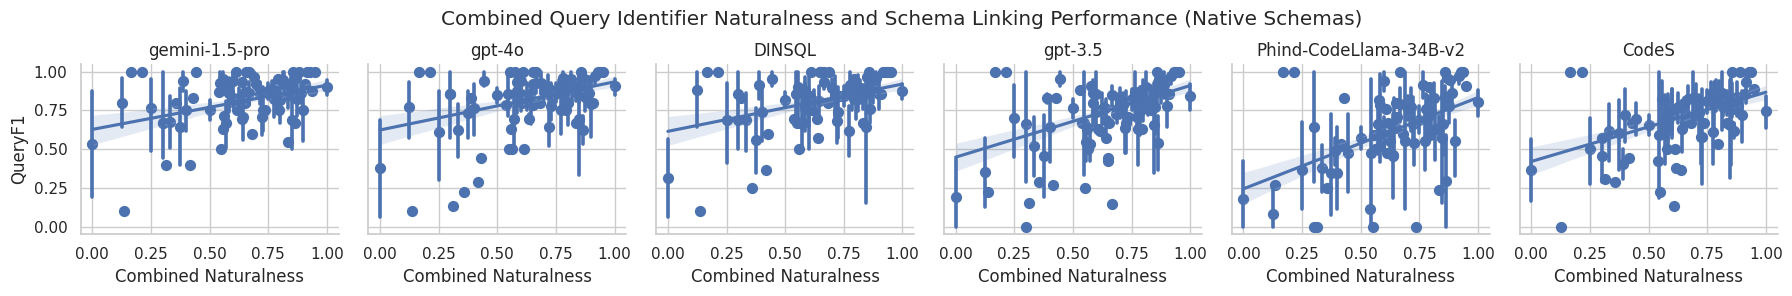

<Figure size 640x480 with 0 Axes>

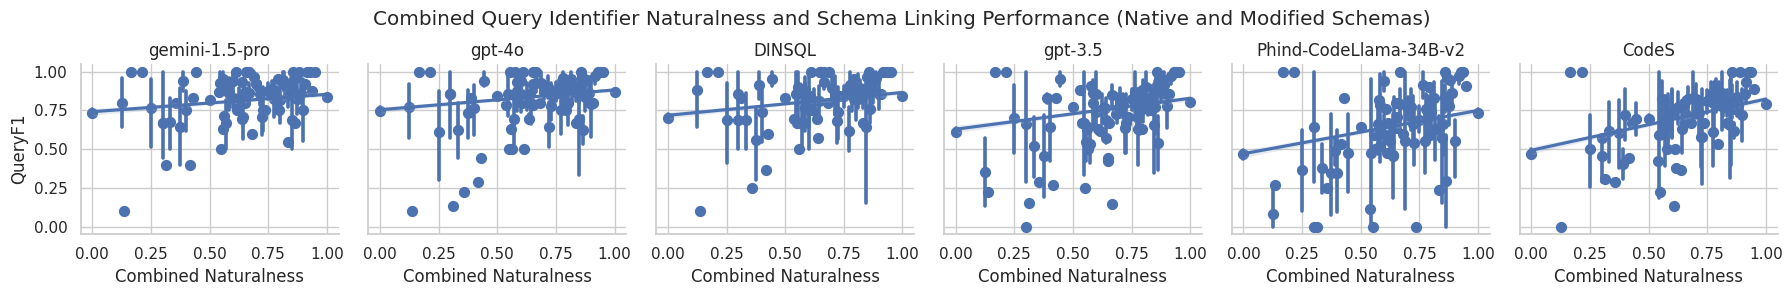

In [32]:
metrics = ['recall', 'precision', 'f1']
metric_labels = ['Recall', 'Precision', 'F1']
for l_ix, metric in enumerate(metrics):
    for native_only in [True, False]:
        if native_only:
            df_query = f"exclude_from_linking == False and naturalness == 'NATIVE'"
            title_insert = "(Native Schemas)"
            filename_insert = "native"
            tau_values = ["0.124", "0.216", "0.202", "0.254"]
        else:
            df_query = f"exclude_from_linking == False"
            title_insert = "(Native and Modified Schemas)"
            filename_insert = "all"
            tau_values = ["0.120", "0.182", "0.166", "0.250"]
        plt.figure()
        
        p_values = ["-1", "-1", "0.001", "0.001", "0.001", "0.001"]
        g = sns.FacetGrid(
            annotation_df.rename(
                columns={'Qg_combined_nat': 'Combined Naturalness'}
                ).sort_values(
                    by='model_order',
                ).query(df_query),
            col='model',
            palette='colorblind',
            aspect=1,
            # markers=model_markers
        )
        g.map(
            sns.regplot, 
            'Combined Naturalness', 
            metric,
            x_jitter=.05,
            x_estimator=np.mean,
            ci=95,
            fit_reg=True,
            # kind="reg", 
            # hue='model'
            )
        g.set_axis_labels('Combined Naturalness', f'Query{metric_labels[l_ix]}')
        # for ax in g.axes.flat[1:]:
        #     ax.set_xlabel('')

        for ix, ax in enumerate(g.axes.flat):
            ax.set_title(
                str(ax.get_title()).replace("model = ", "") 
                # + f", τ = {tau_values[ix]}"
                )
        g.figure.suptitle(f'Combined Query Identifier Naturalness and Schema Linking Performance {title_insert}')
        g.figure.subplots_adjust(top=.80)
        g.figure.xlabel='Combined Naturalness'
        g.savefig(f'./figure_output/combined-query-identifier-naturalness-and-{metric}-performance-{filename_insert}schema-model-facet.pdf', dpi=300)


##### Mean Token-Char Ratio correlation with recall score for all schemas

<Figure size 640x480 with 0 Axes>

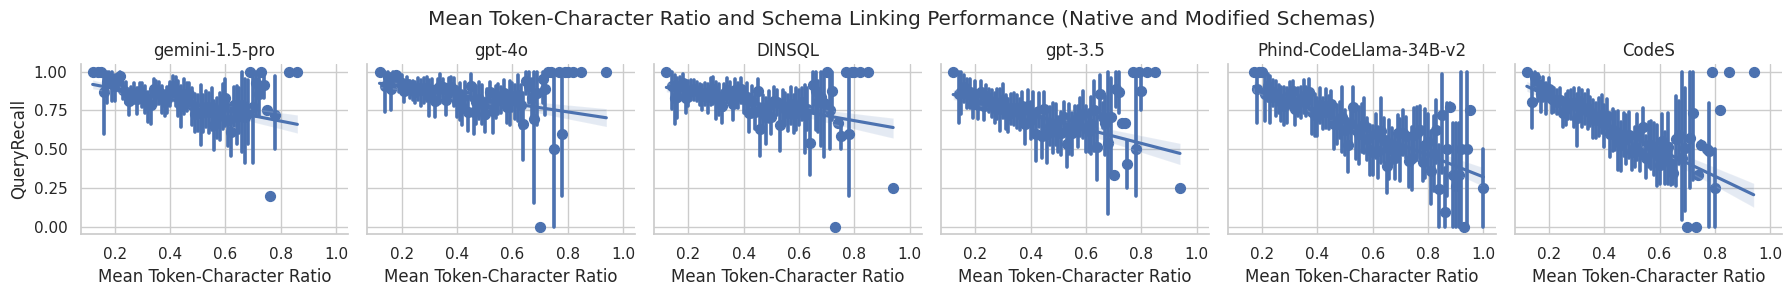

In [33]:
plt.figure()
tau_values = ["-0.153", "-0.157", "-0.155", "-0.263"]
annotation_df["mean_token_char_ratio_rounded"] = annotation_df["mean_token_char_ratio"].round(2)
g = sns.FacetGrid(
    annotation_df.rename(
        columns={'mean_token_char_ratio_rounded': 'Mean Token-Character Ratio'}
        ).sort_values(
            by='model_order',
        ).query("exclude_from_linking == False"),
    col='model',
    palette='colorblind',
    aspect=1,
)
g.map(
    sns.regplot, 
    'Mean Token-Character Ratio', 
    'recall',
    x_jitter=.05,
    x_estimator=np.mean,
    ci=99,
    fit_reg=True,
    )
g.set_axis_labels('Mean Token-Character Ratio', 'QueryRecall')
# for ax in g.axes.flat[1:]:
#     ax.set_xlabel('')
for ix, ax in enumerate(g.axes.flat):
    ax.set_title(
        str(ax.get_title()).replace("model = ", "") 
        # + f", τ = {tau_values[ix]}"
        )
g.figure.suptitle('Mean Token-Character Ratio and Schema Linking Performance (Native and Modified Schemas)')
g.figure.subplots_adjust(top=.80)
g.figure.xlabel='Combined Naturalness'
g.savefig('./figure_output/mean-token-char-ratio-and-recall-performance-allschema-model-facet.pdf', dpi=300)


<Figure size 640x480 with 0 Axes>

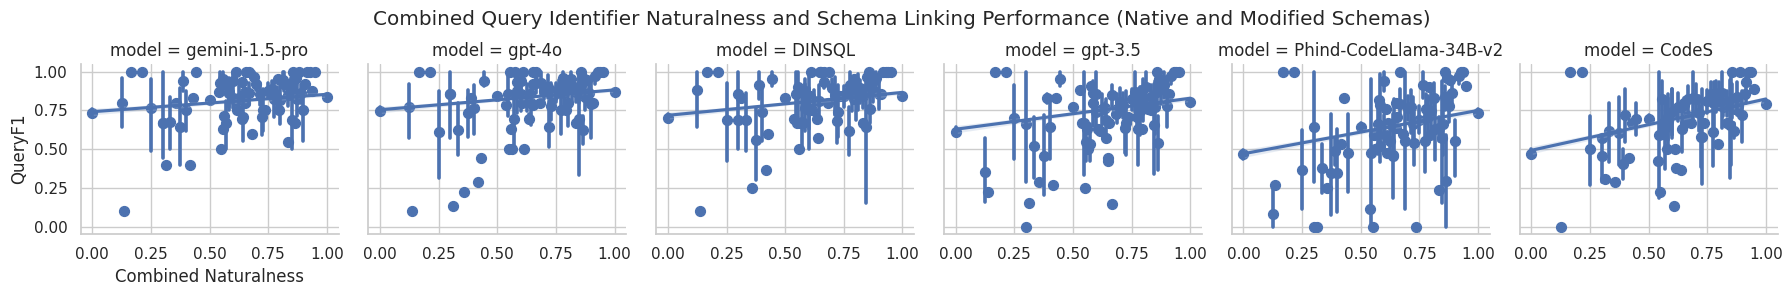

In [34]:
plt.figure()
g = sns.FacetGrid(
    annotation_df.rename(
        columns={'Qg_combined_nat': 'Combined Naturalness'}
        ).sort_values(
            by='model_order',
        ).query("exclude_from_linking == False"),
    col='model',
    palette='colorblind',
    aspect=1,
    # markers=model_markers
)
g.map(
    sns.regplot, 
    'Combined Naturalness', 
    'f1',
    x_jitter=.05,
    x_estimator=np.mean,
    ci=95,
    fit_reg=True,
    # kind="reg", 
    # hue='model'
    )
g.set_axis_labels('Combined Naturalness', 'QueryF1')
for ax in g.axes.flat[1:]:
    ax.set_xlabel('')
g.figure.suptitle('Combined Query Identifier Naturalness and Schema Linking Performance (Native and Modified Schemas)')
g.figure.subplots_adjust(top=.80)
g.figure.xlabel='Combined Naturalness'
g.savefig('./figure_output/combined-query-identifier-naturalness-and-f1-performance-allschema-model-facet.pdf', dpi=300)


##### Separated by database:

<Figure size 640x480 with 0 Axes>

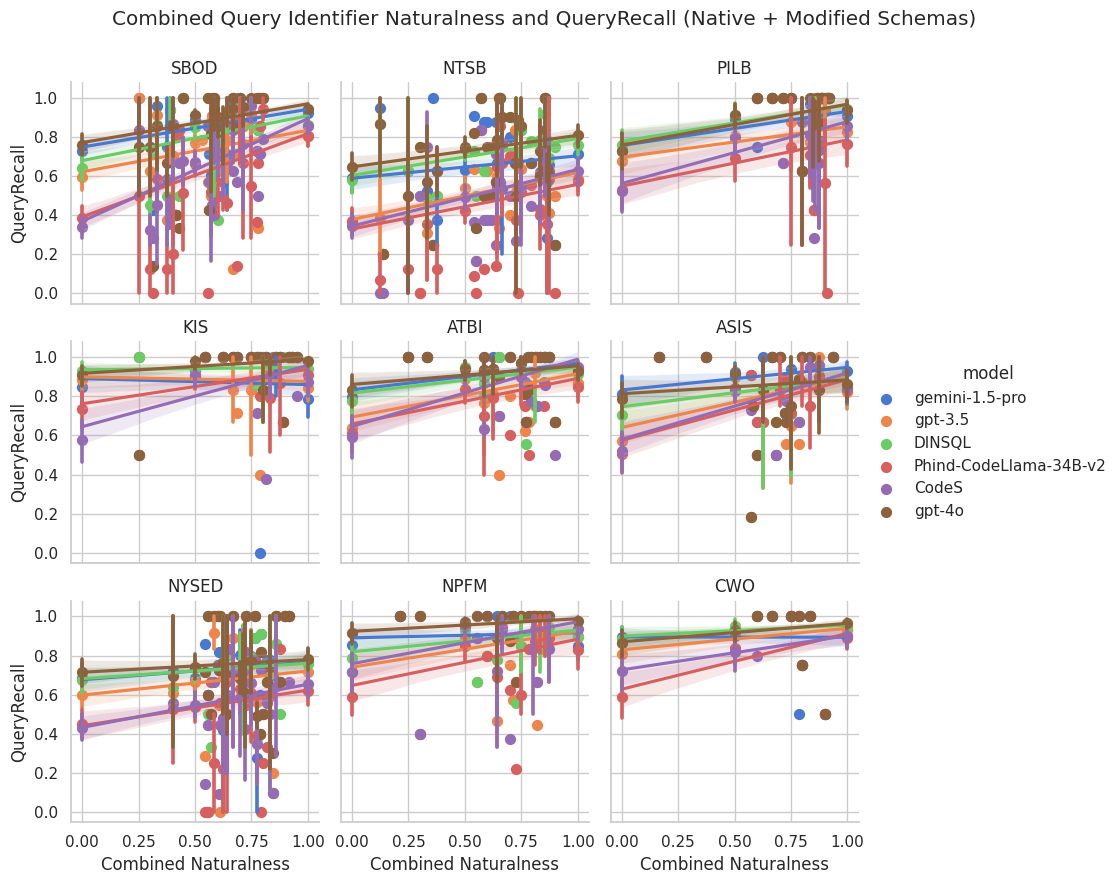

<Figure size 640x480 with 0 Axes>

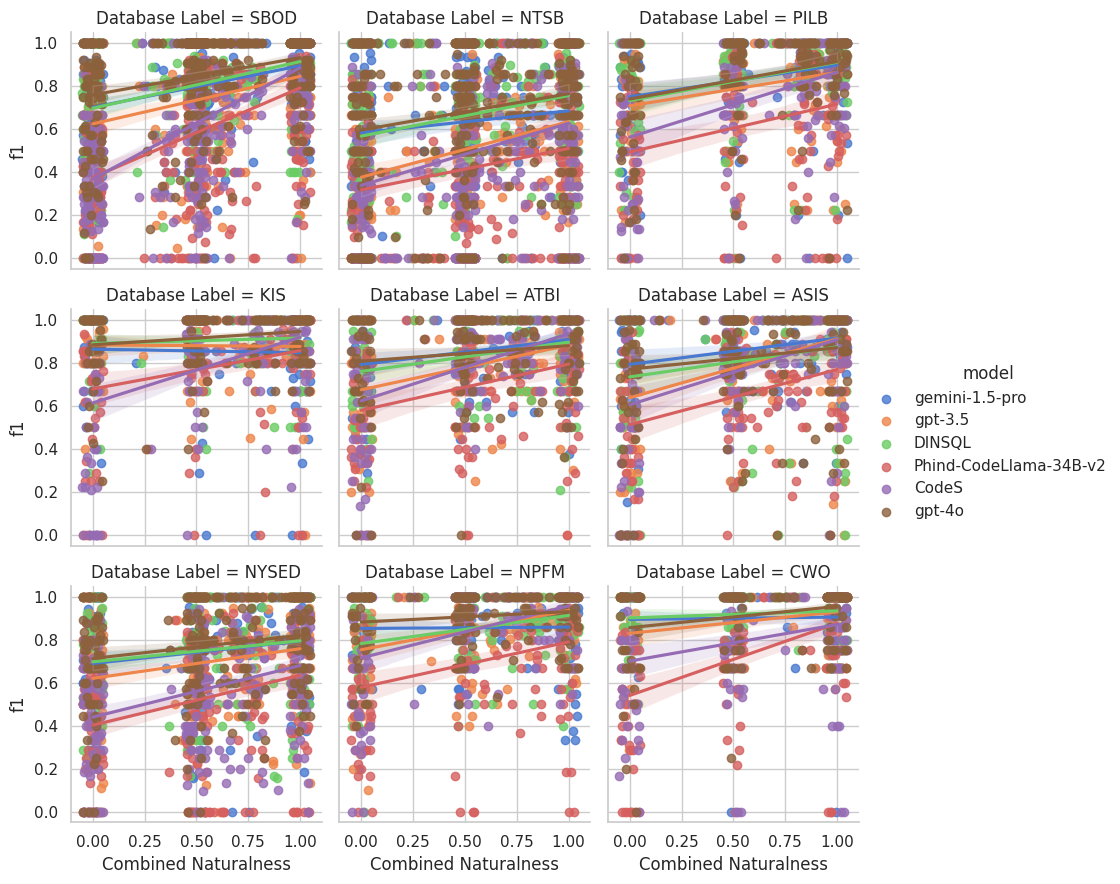

In [35]:
plt.figure()
g = sns.FacetGrid(
    annotation_df.rename(columns={'Qg_combined_nat': 'Combined Naturalness'}),
    col='Database Label',
    palette='muted',
    aspect=1,
    hue='model',
    col_wrap=3,
    # markers=model_markers
)
g.map(
    sns.regplot, 
    'Combined Naturalness', 
    'recall',
    x_jitter=.05,
    x_estimator=np.mean,
    ci=95,
    fit_reg=True,
    # kind="reg", 
    # hue='model'
    )
g.add_legend()
g.set_axis_labels('Combined Naturalness', 'QueryRecall')
g.set_titles(col_template="{col_name}")
g.fig.suptitle('Combined Query Identifier Naturalness and QueryRecall (Native + Modified Schemas)')
g.fig.subplots_adjust(top=.90)
g.savefig('./figure_output/combined-query-identifier-naturalness-and-recall-allschema-model-facet-dbcolumns.pdf', dpi=300)
plt.figure()
g = sns.FacetGrid(
    annotation_df.rename(columns={'Qg_combined_nat': 'Combined Naturalness'}),
    col='Database Label',
    palette='muted',
    aspect=1,
    hue='model',
    col_wrap=3
)
g.map(
    sns.regplot, 
    'Combined Naturalness', 
    'f1',
    x_jitter=.05,
    ci=95,
    fit_reg=True,
    # kind="reg", 
    # hue='model'
    )
g.add_legend()

##### Mean token char ratio x combined naturalness

In [36]:
for c in annotation_df.columns:
    if 'token' in c:
        print(c)

tokenizer_model
question_tokens
prompt_token_count
mean_token_char_ratio
mean_token_char_ratio_rounded


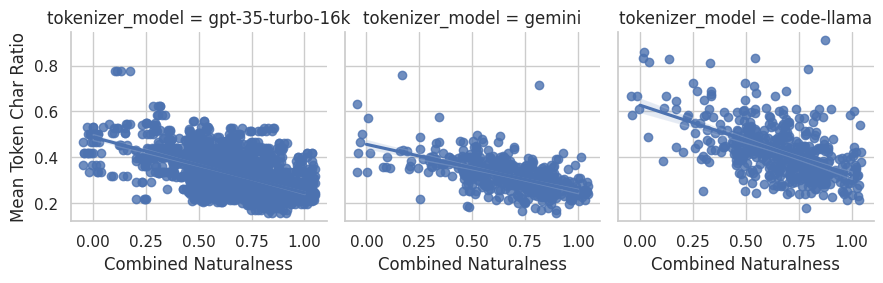

In [37]:
g = sns.FacetGrid(
    annotation_df.query("naturalness == 'NATIVE'"),
    col='tokenizer_model',
    palette='colorblind',
    aspect=1,
    col_wrap=3
)
g.map(
    sns.regplot, 
    'Qg_combined_nat', 
    'mean_token_char_ratio',
    x_jitter=.05,
    ci=95,
    fit_reg=True,
    # kind="reg", 
    # hue='model'
)
g.set_axis_labels('Combined Naturalness', 'Mean Token Char Ratio')




In [38]:
spearman_res = stats.spearmanr(annotation_df.Qg_combined_nat, annotation_df.mean_token_char_ratio)
kendall_res = stats.kendalltau(annotation_df.Qg_combined_nat, annotation_df.mean_token_char_ratio)
print(f"Spearman Correlation between combined naturalness and mean token character ratio, n={annotation_df.shape[0]}:")
print(spearman_res)
print(f"Kendall Tau Correlation between combined naturalness and mean token character ratio, n={annotation_df.shape[0]}:")
print(kendall_res)

Spearman Correlation between combined naturalness and mean token character ratio, n=12082:
SignificanceResult(statistic=np.float64(-0.8207703789307279), pvalue=np.float64(0.0))
Kendall Tau Correlation between combined naturalness and mean token character ratio, n=12082:
SignificanceResult(statistic=np.float64(-0.6657476634847264), pvalue=np.float64(0.0))


Evaluate correlation between combined naturalness and schema linking measurements

In [39]:
for measurement in ['recall', 'precision', 'f1', 'manual_match']:
    models = []
    native_k_tau_stat = []
    native_k_tau_p = []
    native_n = []
    modified_k_tau_stat = []
    modified_k_tau_p = []
    modified_n = []
    for model in annotation_df.sort_values(by='model_order').model.unique():
        df_query = f"model == '{model}'"
        df_query_native = "and naturalness == 'NATIVE'"
        if measurement != 'manual_match':
            df_query_exclude = 'and exclude_from_linking == False'
        else:
            df_query_exclude = ''
        print(f"-----{model}-----")
        model_df = annotation_df.query(f'{df_query} {df_query_native} {df_query_exclude}')
        kendall_res = stats.kendalltau(model_df.Qg_combined_nat, model_df[measurement])
        models.append(model)
        native_k_tau_stat.append(kendall_res.statistic)
        native_k_tau_p.append(kendall_res.pvalue)
        native_n.append(model_df.shape[0])

        model_df = annotation_df.query(f"{df_query} {df_query_exclude}")
        kendall_res = stats.kendalltau(model_df.Qg_combined_nat, model_df[measurement])
        modified_k_tau_stat.append(kendall_res.statistic)
        modified_k_tau_p.append(kendall_res.pvalue)
        modified_n.append(model_df.shape[0])

        k_tau_df_native = pd.DataFrame({
            'Model': models,
            'Kendall-Tau': native_k_tau_stat,
            'P Value': native_k_tau_p,
            'n': native_n,
        })
        k_tau_df_native.to_latex(f'./figure_output/{measurement}_k_tau_df_native.tex', index=False)
        k_tau_df_all = pd.DataFrame({
            'Model': models,
            'Kendall-Tau': modified_k_tau_stat,
            'P Value': modified_k_tau_p,
            'n': modified_n
        })
        k_tau_df_all.to_latex(f'./figure_output/{measurement}_k_tau_df_all.tex', index=False)

-----gemini-1.5-pro-----
-----gpt-4o-----
-----DINSQL-----
-----gpt-3.5-----
-----Phind-CodeLlama-34B-v2-----
-----CodeS-----
-----gemini-1.5-pro-----
-----gpt-4o-----
-----DINSQL-----
-----gpt-3.5-----
-----Phind-CodeLlama-34B-v2-----
-----CodeS-----
-----gemini-1.5-pro-----
-----gpt-4o-----
-----DINSQL-----
-----gpt-3.5-----
-----Phind-CodeLlama-34B-v2-----
-----CodeS-----
-----gemini-1.5-pro-----
-----gpt-4o-----
-----DINSQL-----
-----gpt-3.5-----
-----Phind-CodeLlama-34B-v2-----
-----CodeS-----


Evaluate correlation between specific naturalness level proportions and linking performance

In [40]:
for nat_level_pct in [
    'Qg_identifier_N1_pct', 'Qg_identifier_N2_pct', 
    'Qg_identifier_N3_pct', 'mean_token_char_ratio'
    ]:
    for measurement in ['recall', 'precision', 'f1', 'manual_match']:
        models = []
        native_k_tau_stat = []
        native_k_tau_p = []
        native_n = []
        modified_k_tau_stat = []
        modified_k_tau_p = []
        modified_n = []
        for model in annotation_df.sort_values(by='model_order').model.unique():
            df_query = f"model == '{model}'"
            df_query_native = "and naturalness == 'NATIVE'"
            if measurement != 'manual_match':
                df_query_exclude = 'and exclude_from_linking == False'
            else:
                df_query_exclude = ''
            print(f"-----{model}-----")
            model_df = annotation_df.query(f'{df_query} {df_query_native} {df_query_exclude}')
            kendall_res = stats.kendalltau(model_df[nat_level_pct], model_df[measurement])
            models.append(model)
            native_k_tau_stat.append(kendall_res.statistic)
            native_k_tau_p.append(kendall_res.pvalue)
            native_n.append(model_df.shape[0])

            model_df = annotation_df.query(f"{df_query} {df_query_exclude}")
            kendall_res = stats.kendalltau(model_df[nat_level_pct], model_df[measurement])
            modified_k_tau_stat.append(kendall_res.statistic)
            modified_k_tau_p.append(kendall_res.pvalue)
            modified_n.append(model_df.shape[0])

            k_tau_df_native = pd.DataFrame({
                'Model': models,
                'Kendall-Tau': native_k_tau_stat,
                'P Value': native_k_tau_p,
                'n': native_n,
            })
            k_tau_df_native.to_latex(f'./figure_output/{nat_level_pct}_{measurement}_k_tau_df_native.tex', index=False)
            k_tau_df_all = pd.DataFrame({
                'Model': models,
                'Kendall-Tau': modified_k_tau_stat,
                'P Value': modified_k_tau_p,
                'n': modified_n
            })
            k_tau_df_all.to_latex(f'./figure_output/{nat_level_pct}_{measurement}_k_tau_df_all.tex', index=False)

-----gemini-1.5-pro-----
-----gpt-4o-----
-----DINSQL-----
-----gpt-3.5-----
-----Phind-CodeLlama-34B-v2-----
-----CodeS-----
-----gemini-1.5-pro-----
-----gpt-4o-----
-----DINSQL-----
-----gpt-3.5-----
-----Phind-CodeLlama-34B-v2-----
-----CodeS-----
-----gemini-1.5-pro-----
-----gpt-4o-----
-----DINSQL-----
-----gpt-3.5-----
-----Phind-CodeLlama-34B-v2-----
-----CodeS-----
-----gemini-1.5-pro-----
-----gpt-4o-----
-----DINSQL-----
-----gpt-3.5-----
-----Phind-CodeLlama-34B-v2-----
-----CodeS-----
-----gemini-1.5-pro-----
-----gpt-4o-----
-----DINSQL-----
-----gpt-3.5-----
-----Phind-CodeLlama-34B-v2-----
-----CodeS-----
-----gemini-1.5-pro-----
-----gpt-4o-----
-----DINSQL-----
-----gpt-3.5-----
-----Phind-CodeLlama-34B-v2-----
-----CodeS-----
-----gemini-1.5-pro-----
-----gpt-4o-----
-----DINSQL-----
-----gpt-3.5-----
-----Phind-CodeLlama-34B-v2-----
-----CodeS-----
-----gemini-1.5-pro-----
-----gpt-4o-----
-----DINSQL-----
-----gpt-3.5-----
-----Phind-CodeLlama-34B-v2-----
-----Cod

In [41]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
for model in annotation_df.model.unique():
    print(f"#### MODEL {model} ####")
    X = annotation_df.query(f"model == '{model}'").dropna(how="any")[x]
    local_x = [
        # 'schema_combined_nat', 
        'Qg_combined_nat',
        'schema_tab_count',
        'schema_col_count',
        # 'prompt_token_count',
        'query_stat_count',
        # 'mean_token_char_ratio'
        ]
    y = annotation_df.query(f"model == '{model}'").dropna(how="any", subset=local_x).recall
    print(y.shape[0])
    X = annotation_df.query(f"model == '{model}'").dropna(how="any", subset=local_x)[local_x]
    print(X.shape[0])
    X2 = sm.add_constant(X)

    est = sm.OLS(y, X2)
    est2 = est.fit()
    print(est2.summary())



#### MODEL gemini-1.5-pro ####
2012
2012
                            OLS Regression Results                            
Dep. Variable:                 recall   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     60.41
Date:                Mon, 02 Dec 2024   Prob (F-statistic):           3.09e-48
Time:                        11:29:31   Log-Likelihood:                -126.14
No. Observations:                2012   AIC:                             262.3
Df Residuals:                    2007   BIC:                             290.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

### DB-level schema linking analysis

##### F1 score distributions by database naturalness override setting

In [42]:
for c in annotation_df.columns:
    print(c)

tokenizer_model
database
naturalness
question_number
question
hints
notes
query_gold
schema_pruning
prompt
query_predicted
query_predicted_on_naturalized_schema
tab_naturalness_modifier
query_stats
Qg_col_N1
Qg_tot_cols
Qg_col_N2
Qg_col_N3
Qg_tab_N1
Qg_tot_tabs
Qg_tab_N2
Qg_tab_N3
schema_col_N1
schema_col_N2
schema_col_N3
schema_tab_N1
schema_tab_N2
schema_tab_N3
schema_tab_count
schema_col_count
Qg_col_N1_pct
Qg_col_N2_pct
Qg_col_N3_pct
Qg_tab_N1_pct
Qg_tab_N2_pct
Qg_tab_N3_pct
schema_col_N1_pct
schema_col_N2_pct
schema_col_N3_pct
schema_tab_N1_pct
schema_tab_N2_pct
schema_tab_N3_pct
result_set_match
result_set_compare_note
string_match
matching_tables
matching_columns
missing_tables
missing_columns
extra_tables
extra_columns
recall
precision
f1
manual_match
review_notes
model
source_file
question_number_combined_modules
naturalness_order
schema_identifier_N1
schema_identifier_N2
schema_identifier_N3
schema_identifier_N1_pct
schema_identifier_N2_pct
schema_identifier_N3_pct
Qg_identif

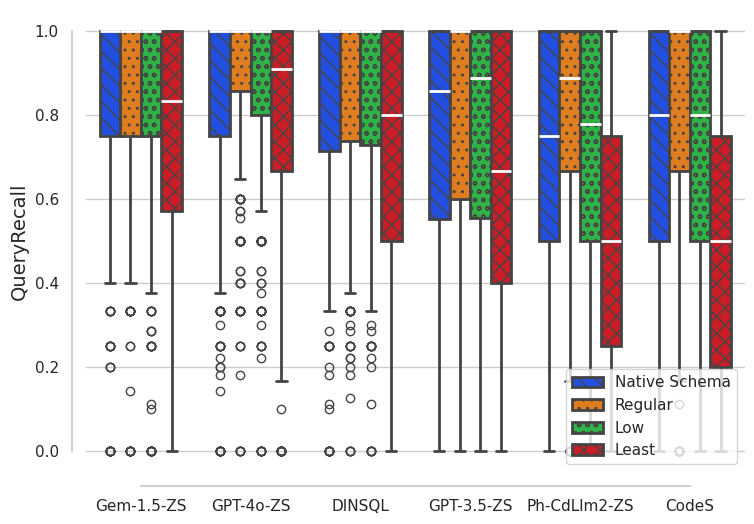

In [43]:

plt.figure(figsize=(8.5, 6))
sns.set_theme(style="whitegrid")
ax = sns.boxplot(
    data=annotation_df.query(
        "exclude_from_linking == False and naturalness_label != 'Regular-Improved'"
        ).sort_values(by=['naturalness_order', 'model_order']),
    # hue='col_naturalness_modifier',
    # order=['NATIVE', 'N1', 'N2', 'N3'],
    # x='col_naturalness_modifier',
    x='model_abbreviated',
    y='recall',
    # palette=["m", "g", 'b', 'orange'],
    palette='bright',
    hue = 'naturalness_label',
    linewidth=2,
    medianprops={'color': 'white', 'ls': '-', 'lw': 2},
    width=.75
    )

hatches = ['\\\\', '..', 'oo', 'xx']
for i, thisbar in enumerate(ax.patches):
    if i in [0, 1, 2, 3, 4, 5, 24]:
        thisbar.set_hatch(hatches[0])
    elif i in [6, 7, 8, 9, 10, 11, 25]:
        thisbar.set_hatch(hatches[1])
    elif i in [12, 13, 14, 15, 16, 17, 26]:
        thisbar.set_hatch(hatches[2])
    else:
        thisbar.set_hatch(hatches[3])
    
sns.despine(offset=10, trim=True)
plt.legend(loc='lower right')
plt.ylabel('QueryRecall', size=14)
plt.xlabel('', size=14)

ax.figure.savefig('./figure_output/recall-boxplot-db-combined.pdf', dpi=300, bbox_inches='tight')

##### F1 Scores by model, naturalness level, and database

/tmp/ipykernel_38543/1699637928.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  grid = sns.catplot(
/tmp/ipykernel_38543/1699637928.py:2: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  grid = sns.catplot(
/tmp/ipykernel_38543/1699637928.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  grid = sns.catplot(
/tmp/ipykernel_38543/1699637928.py:2: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  grid = sns.catplot(
/tmp/ipykernel_38543/1699637928.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.

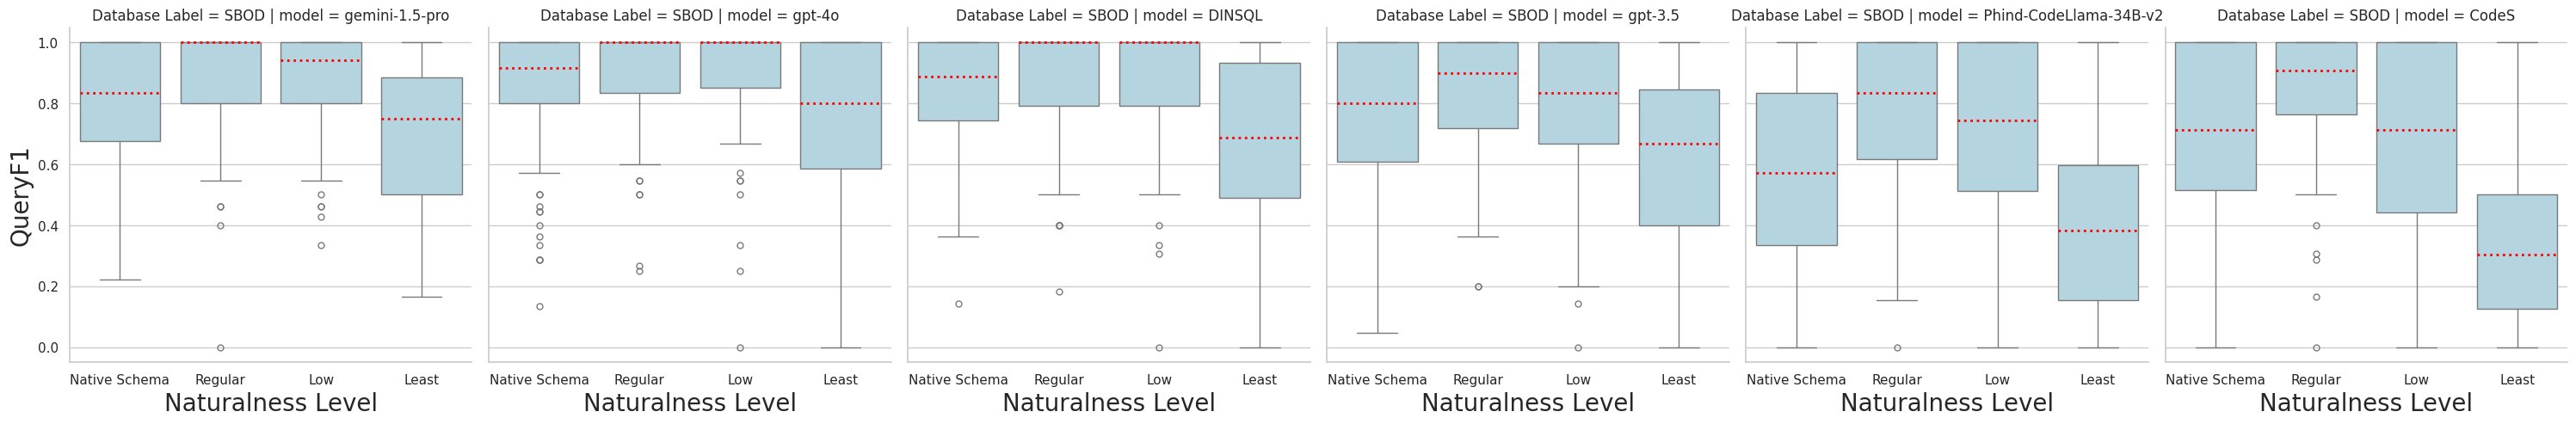

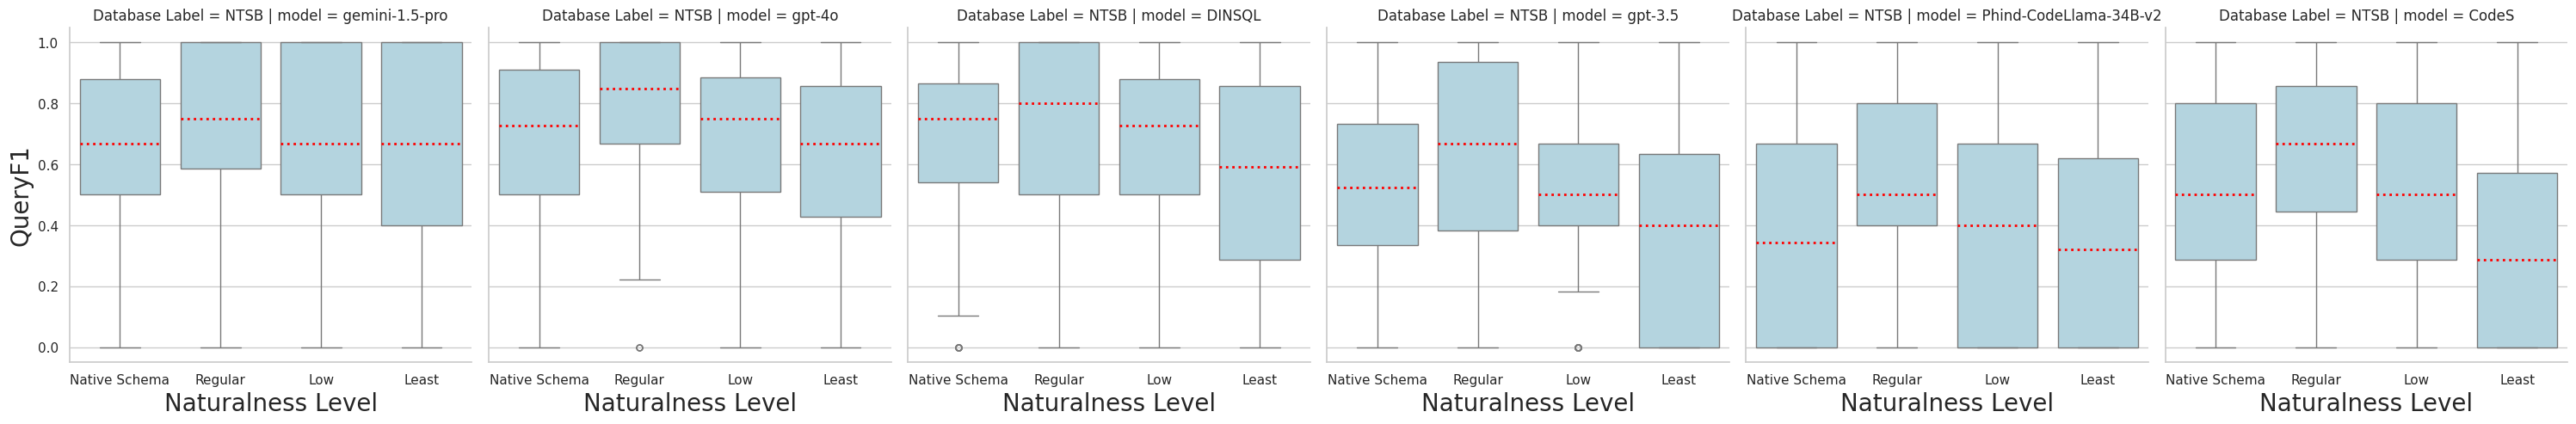

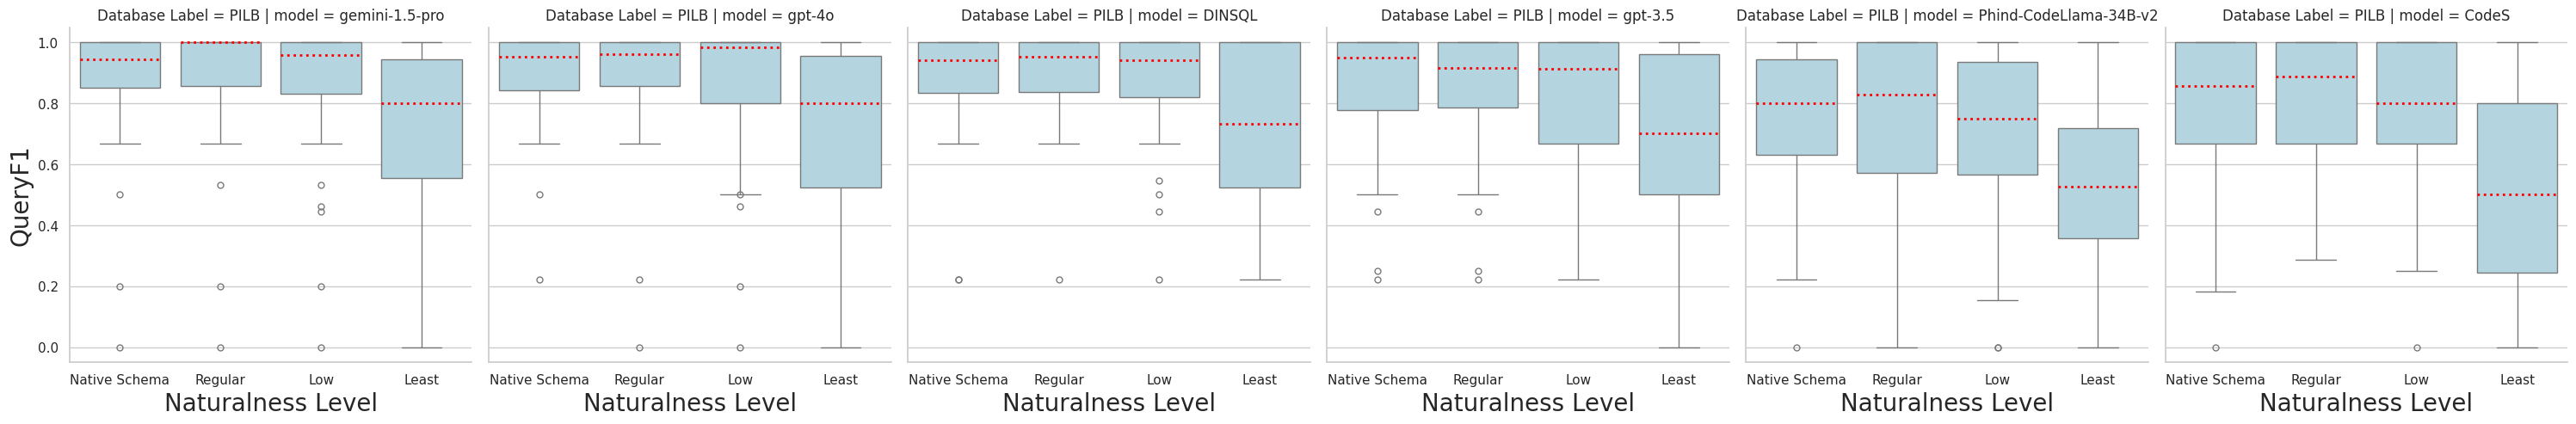

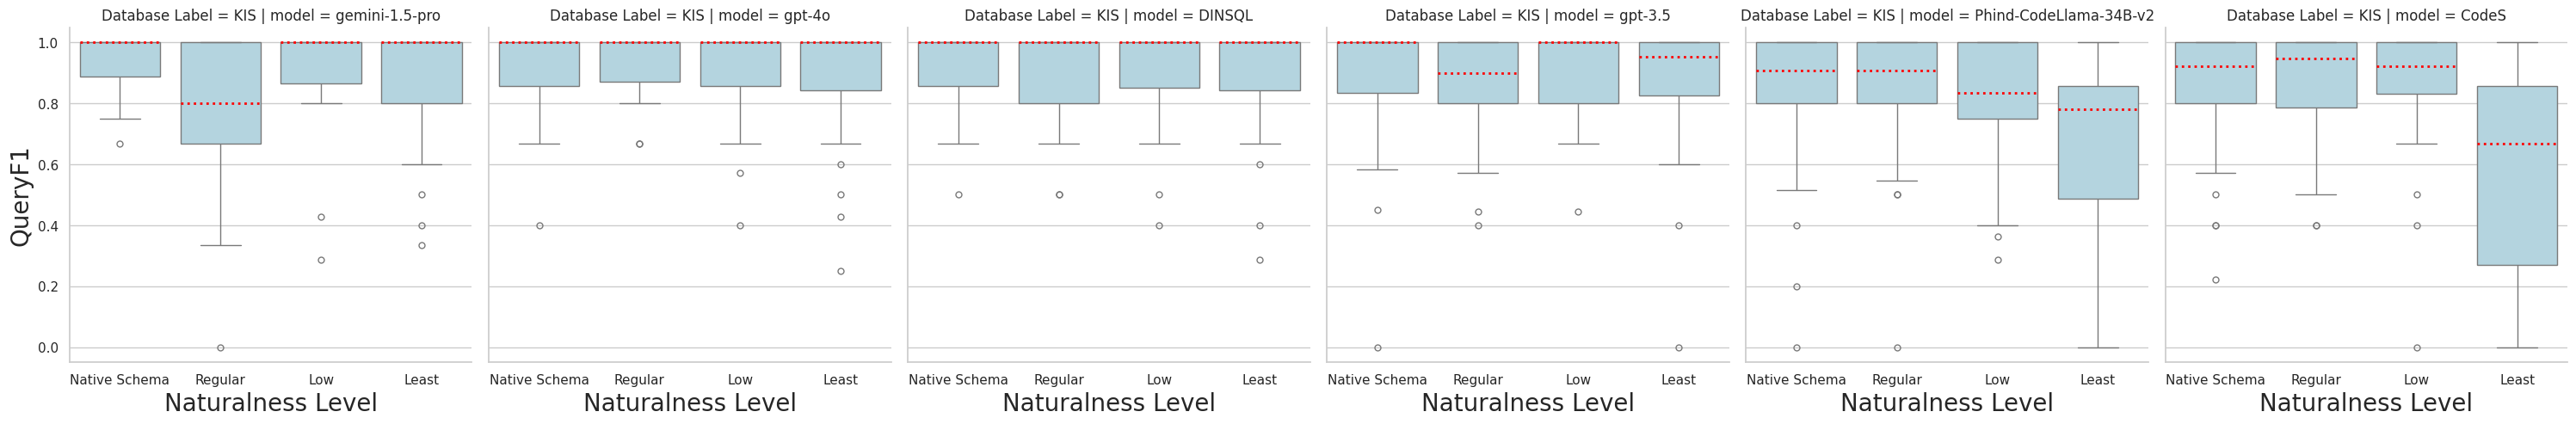

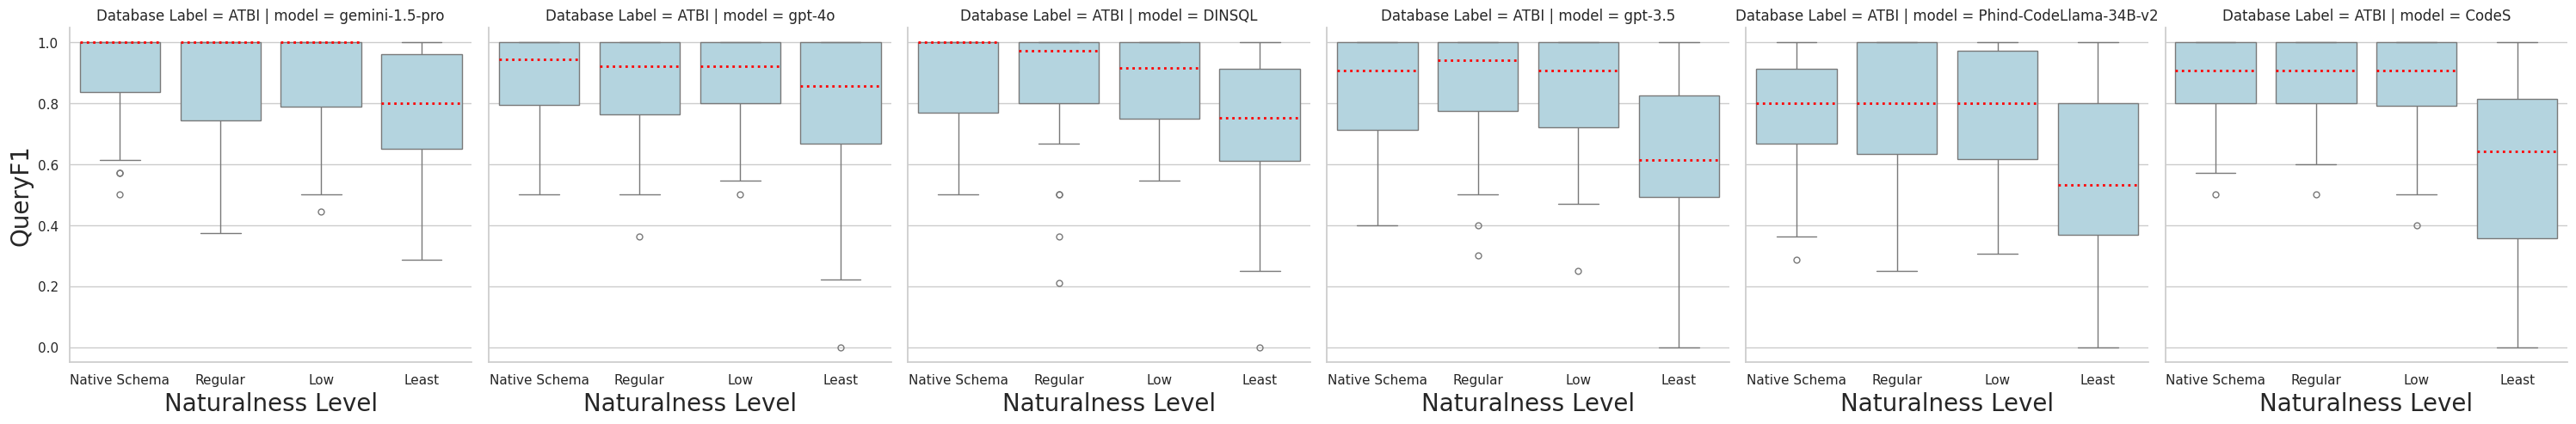

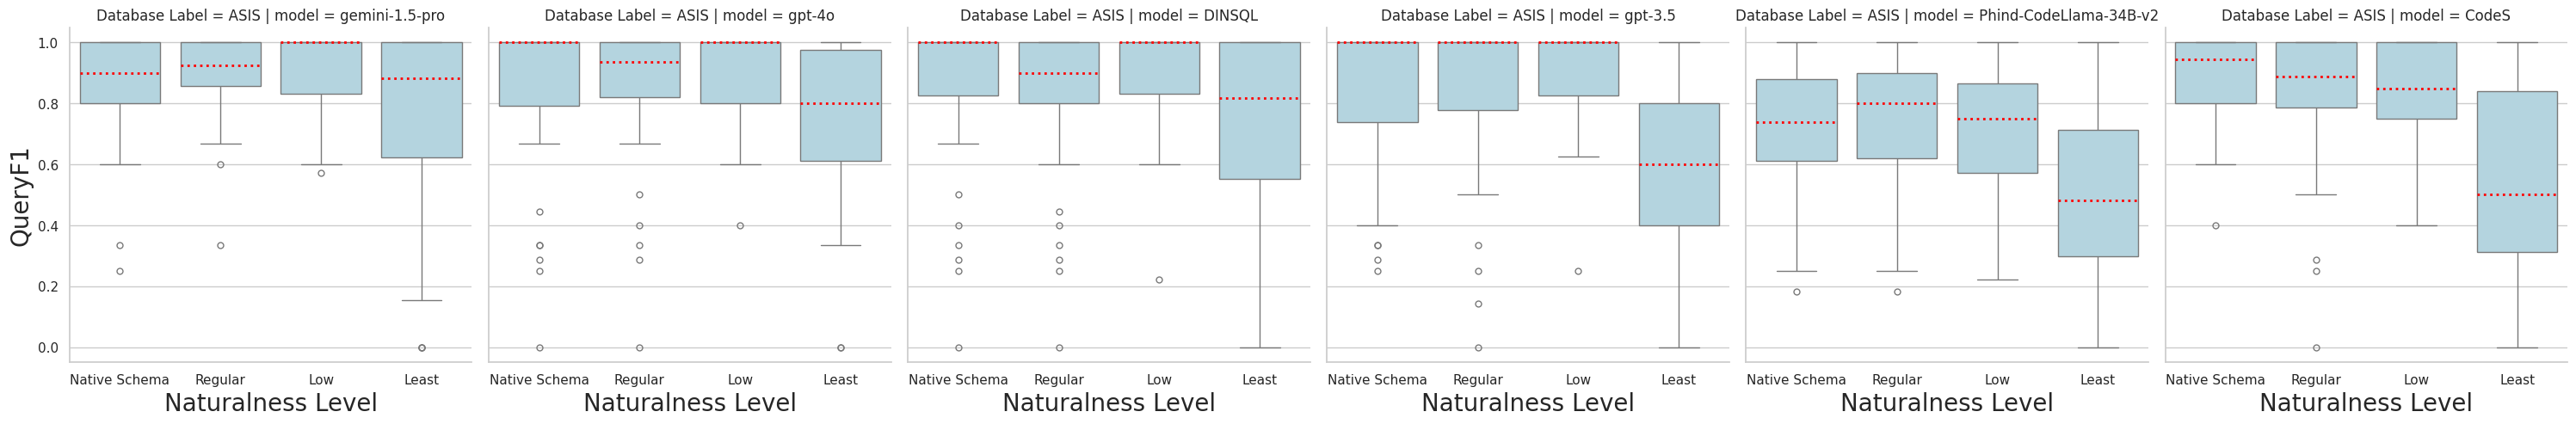

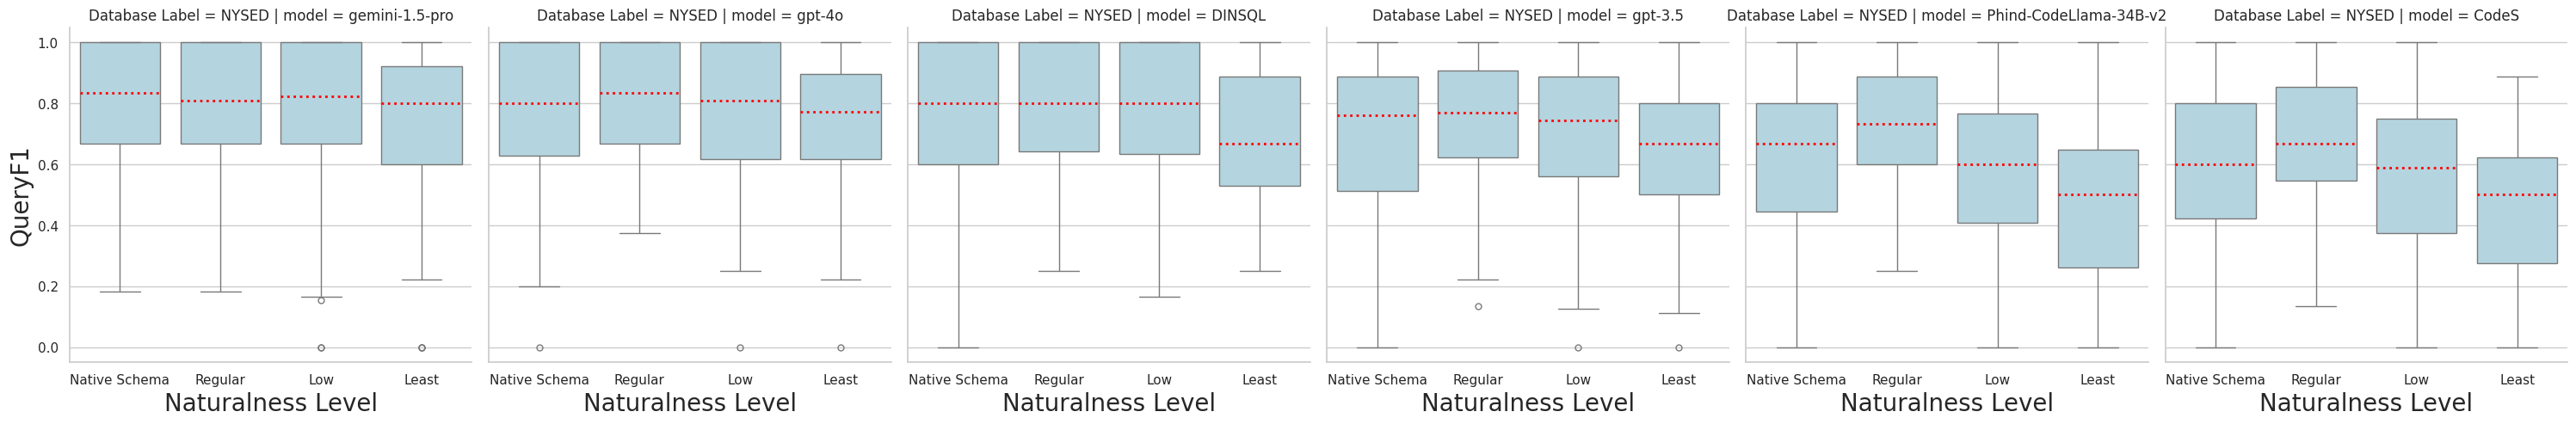

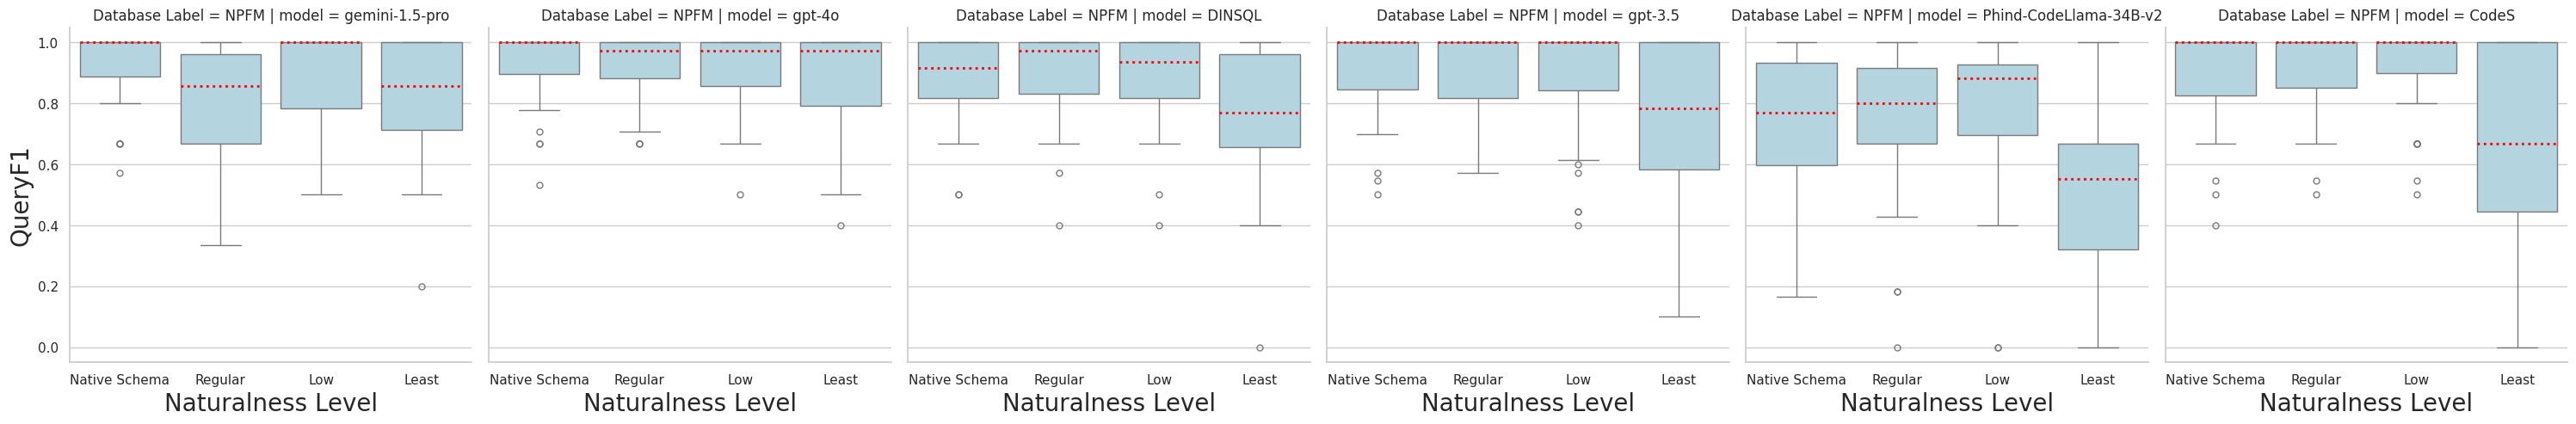

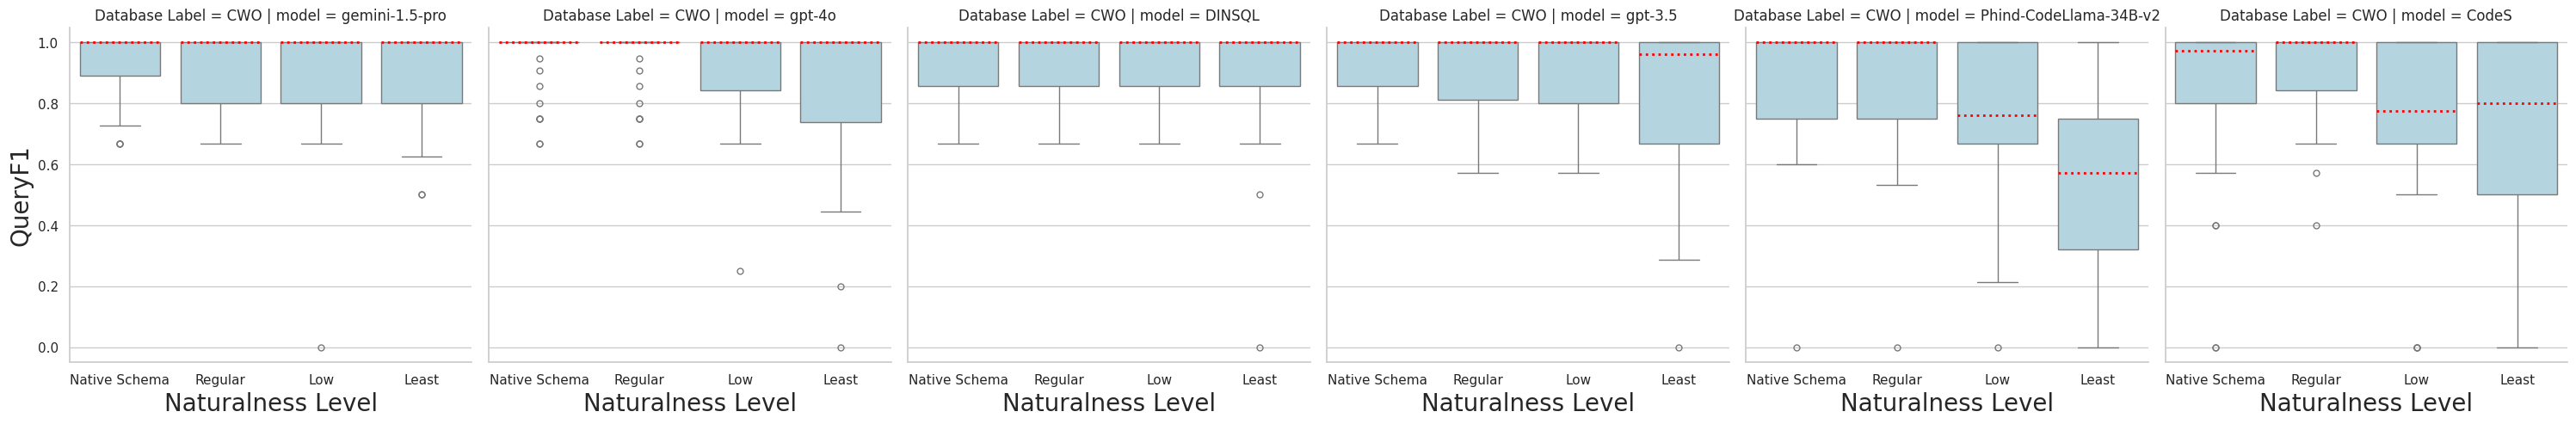

In [44]:
for db_label in annotation_df["Database Label"].unique():
    grid = sns.catplot(
        data=annotation_df.sort_values(
                by=["model_order", "naturalness_order"]
            ).query(
                f"exclude_from_linking == False and `Database Label` == '{db_label}'"
            ),
        x='naturalness_label',
        y='f1',
        col='model',
        row='Database Label',
        kind='box',
        palette=['#ADD8E6'],
        medianprops={'color': 'red', 'ls': 'dotted', 'lw': 2}
        )
    grid.set_axis_labels('Naturalness Level', 'QueryF1', size=20)
    grid.fig.savefig(f'./figure_output/natlevel-model-f1-boxplot-{db_label}.pdf', dpi=300)

##### Recall scores by model, naturalness level, and database

/tmp/ipykernel_38543/717203067.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([


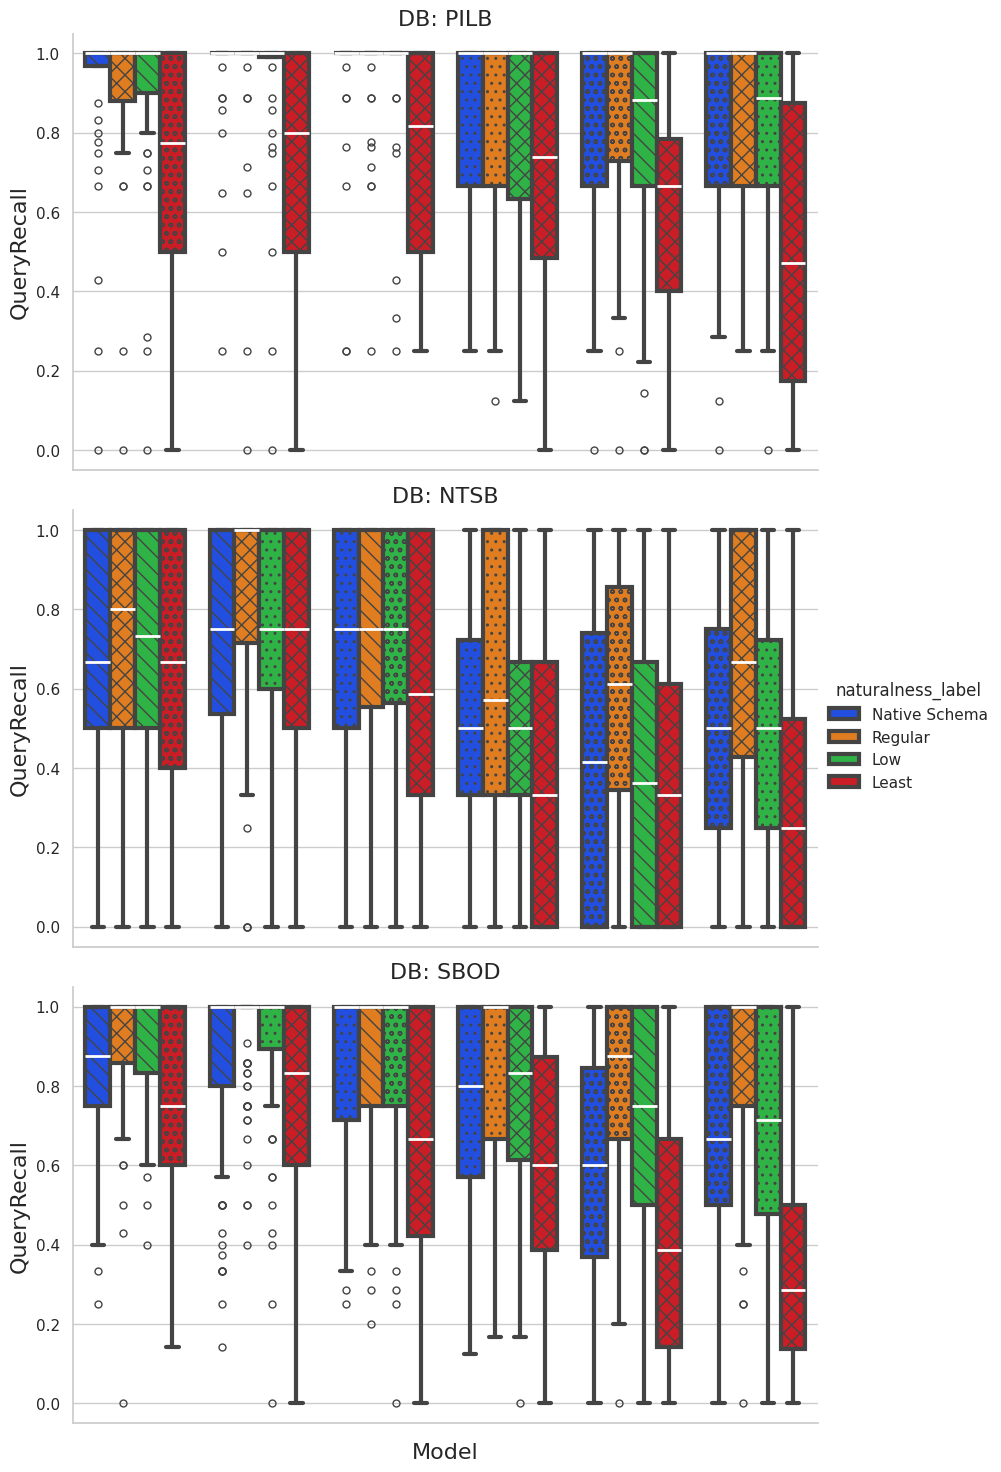

In [45]:
sns.set_theme(style="whitegrid")
grid = sns.catplot(
    data=annotation_df.sort_values(
            by=[ "naturalness_order", "model_order", "schema_identifier_N3_pct"]
        ).query(
            f"exclude_from_linking == False and `Database Label` in ['NTSB', 'PILB', 'SBOD']"
        ),
    x='model_abbreviated',
    hue='naturalness_label',
    y='recall',
    col='Database Label',
    kind='box',
    palette='bright',
    linewidth=3,
    medianprops={'color': 'white', 'ls': 'solid', 'lw': 2},
    legend=True,
    aspect=1.7,
    col_wrap=1
    )
grid.set_axis_labels('Model', 'QueryRecall', size=16)
for ax in grid.axes.flat:
    ax.set_title(ax.get_title().replace("Database Label = ", "DB: "), size=16)
    ax.set_xticklabels([
        l.get_text().replace("-34B-v2", "") 
        for l in ax.get_xticklabels()
        ], size=12)
hatches = ['\\\\', '..', 'oo', 'xx']
for j, f in enumerate(grid.axes.flat):
    for i, thisbar in enumerate(f.patches):
        if i in [0, 1, 8, 12, 16]:
            thisbar.set_hatch(hatches[0])
        elif i in [2, 3, 9, 13, 17]:
            thisbar.set_hatch(hatches[1])
        elif i in [4, 5, 10, 14, 18]:
            thisbar.set_hatch(hatches[2])
        else:
            thisbar.set_hatch(hatches[3])

# grid.add_legend()
# grid.legend.set_title('Level', prop={'size': 18})
# for entry in grid.legend.get_texts():
#     print(entry)
#     entry.set_text(entry.get_text().replace(" Schema", ""))
#     entry.set_fontsize(16)
        
# grid.fig.tight_layout(pad=3.5)

# grid.set_xticklabels(["Native", "Regular", "Low", "Least", "Regular-Improved"], size=18)
grid.fig.savefig(f'./figure_output/natlevel-model-recall-boxplot-db-subset-1.pdf', dpi=300)

/tmp/ipykernel_38543/2300558307.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  grid = sns.catplot(
/tmp/ipykernel_38543/2300558307.py:2: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  grid = sns.catplot(
/tmp/ipykernel_38543/2300558307.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  grid = sns.catplot(
/tmp/ipykernel_38543/2300558307.py:2: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  grid = sns.catplot(
/tmp/ipykernel_38543/2300558307.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.

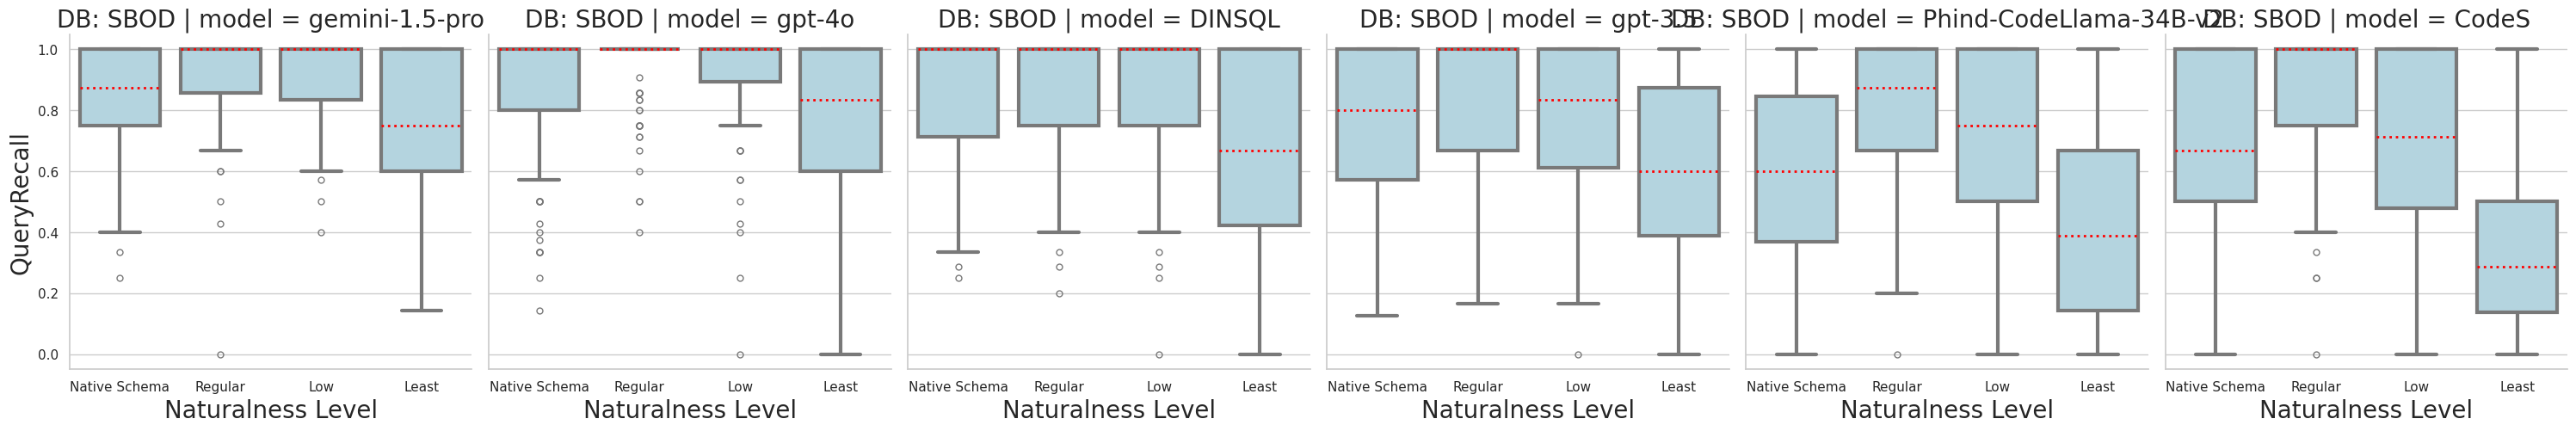

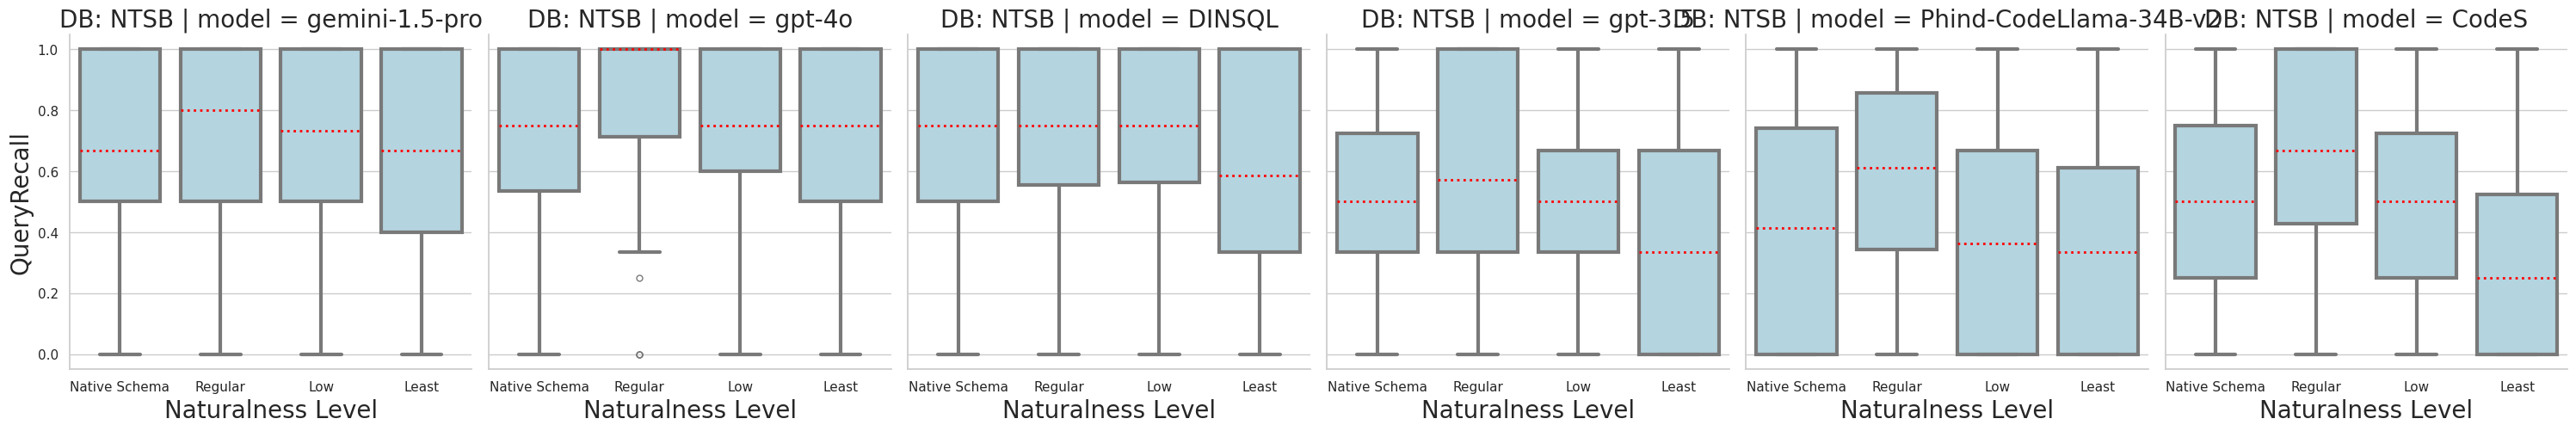

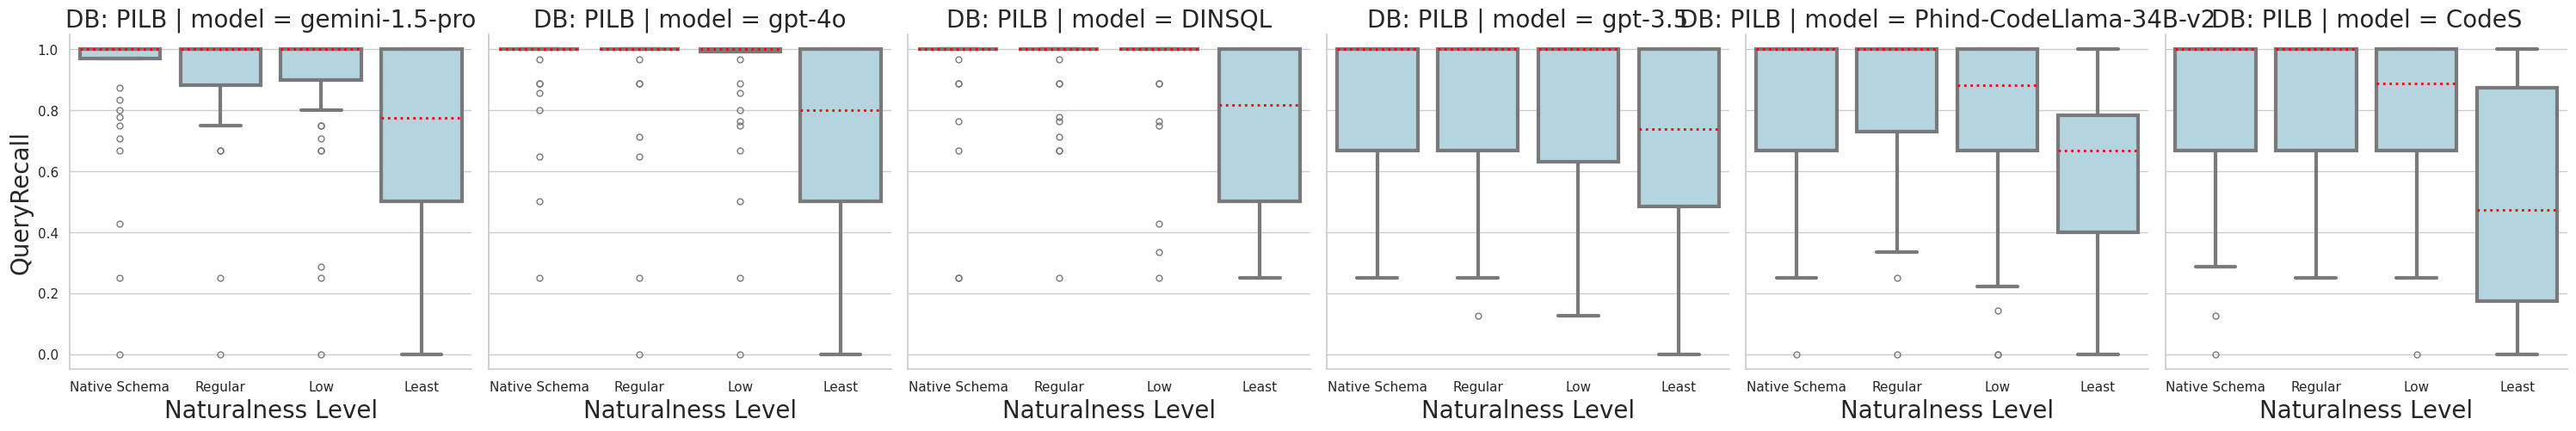

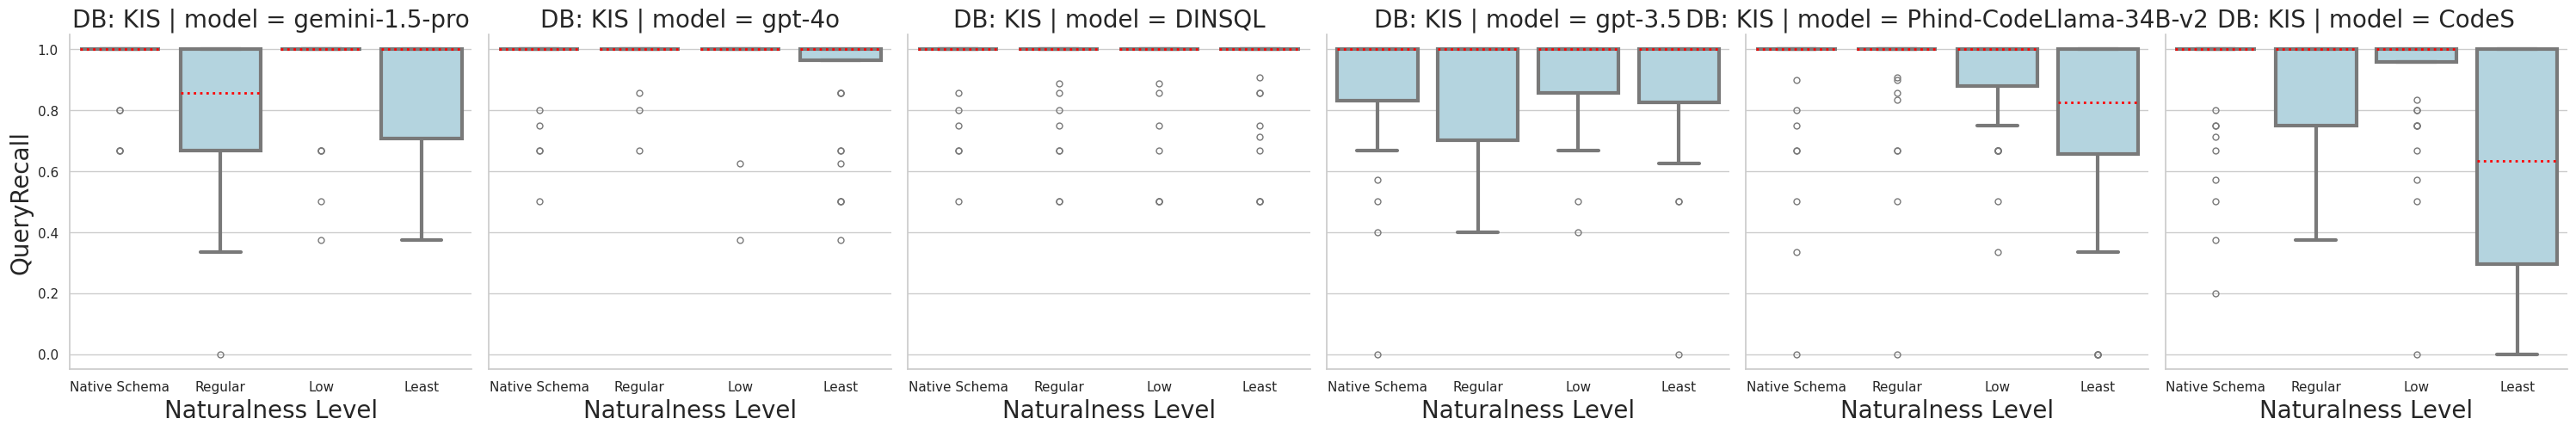

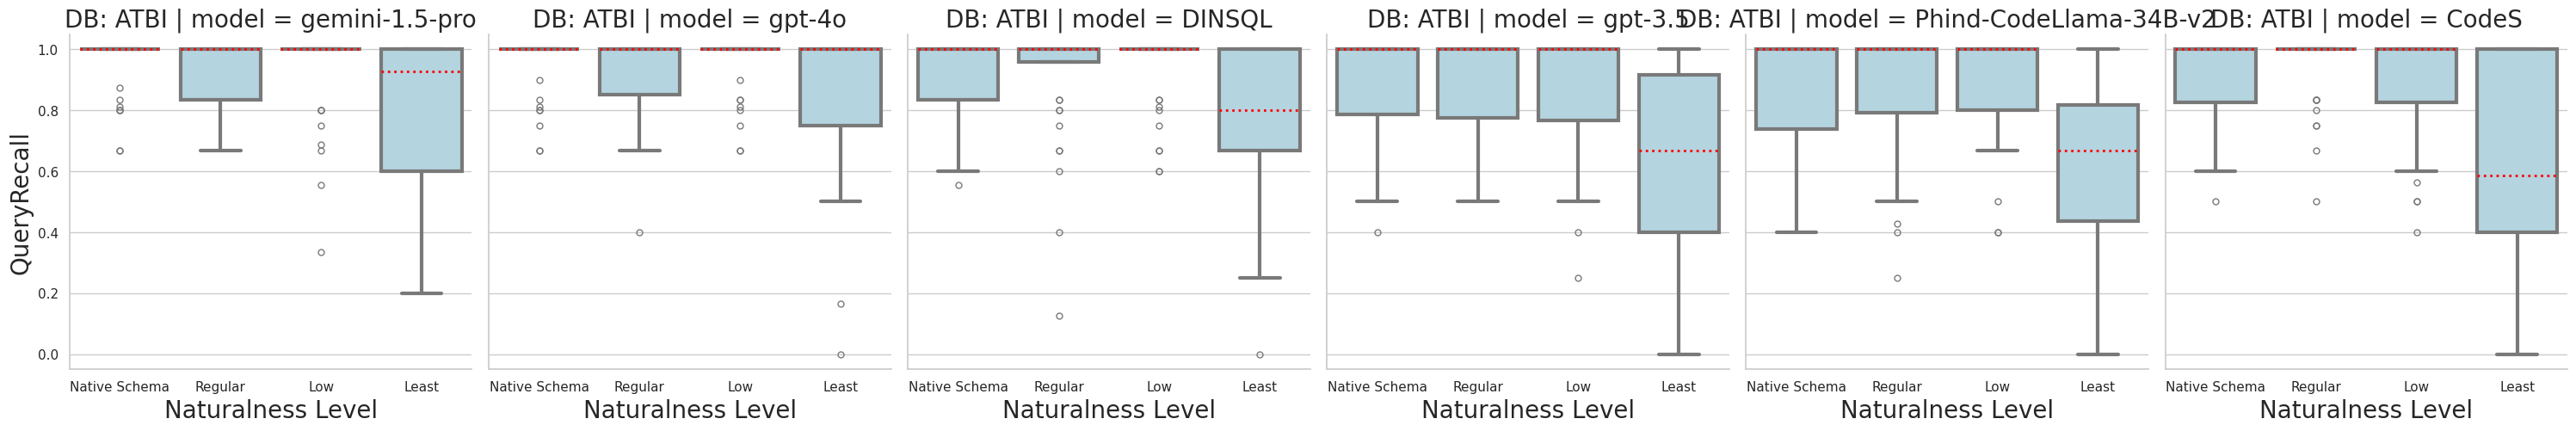

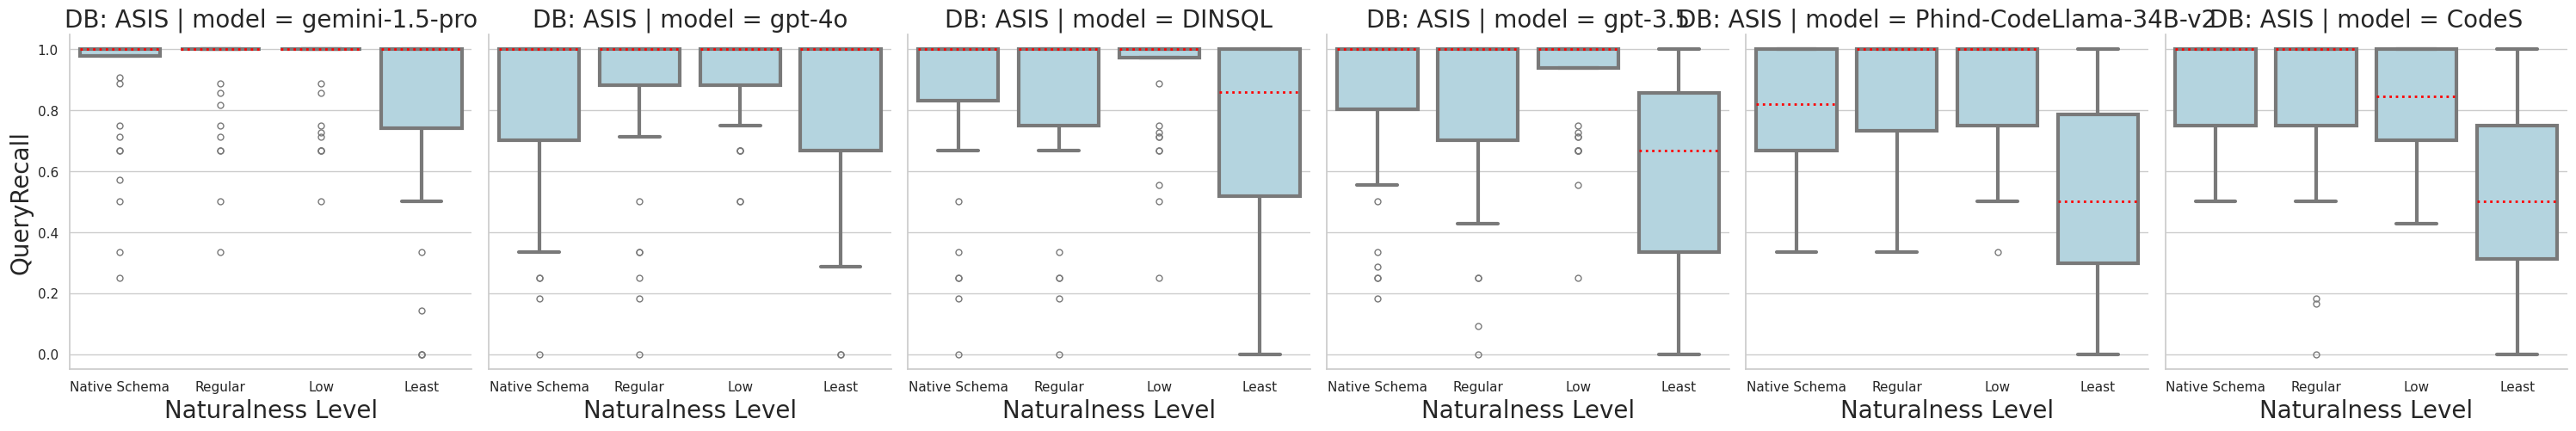

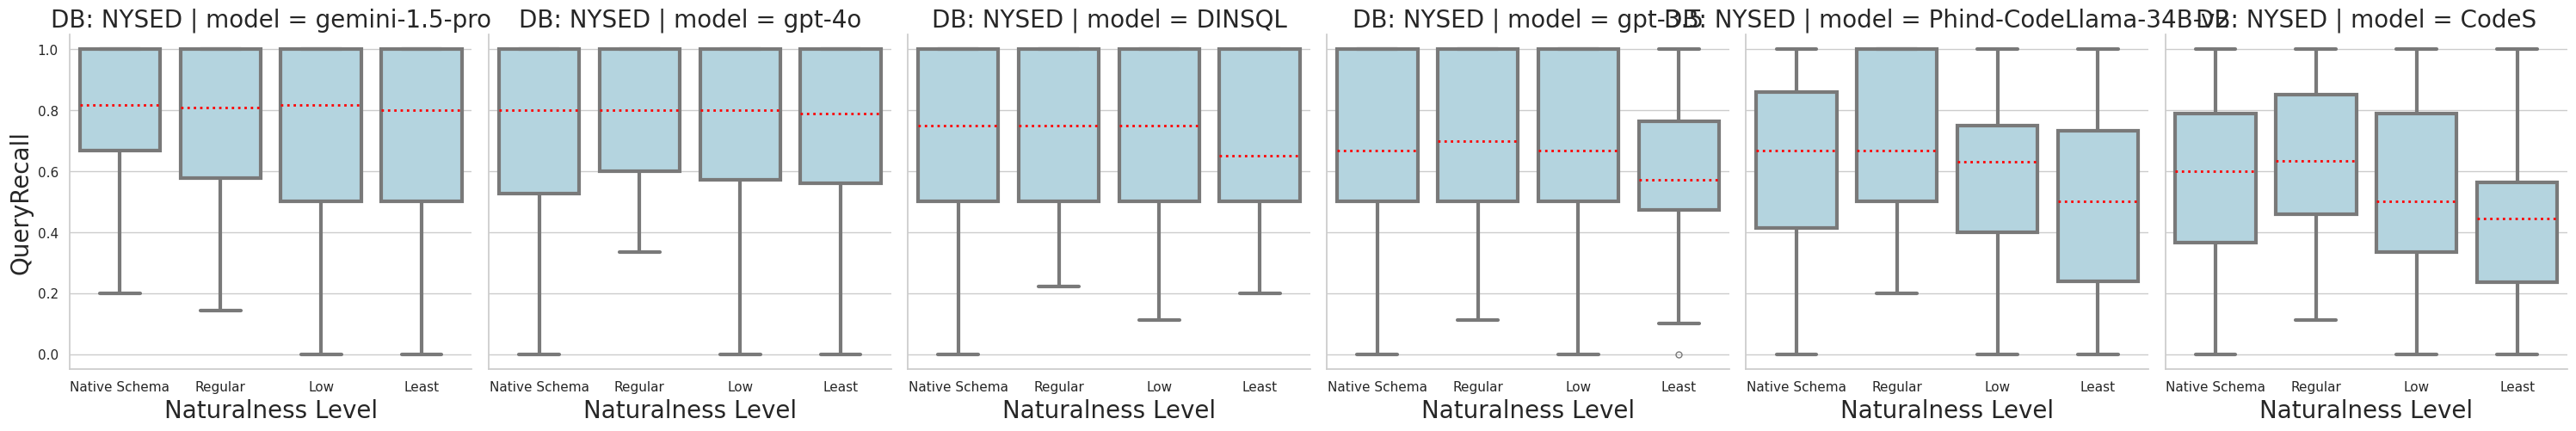

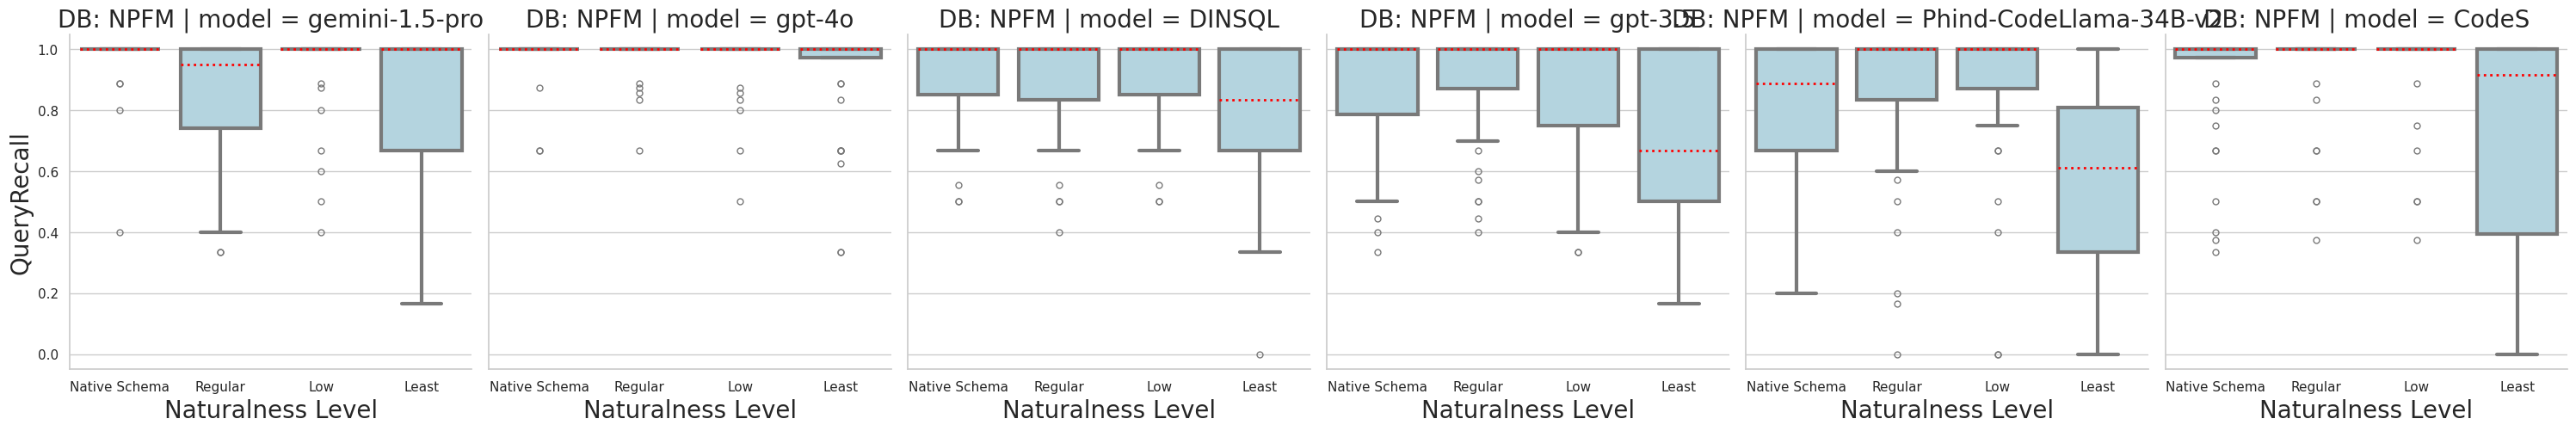

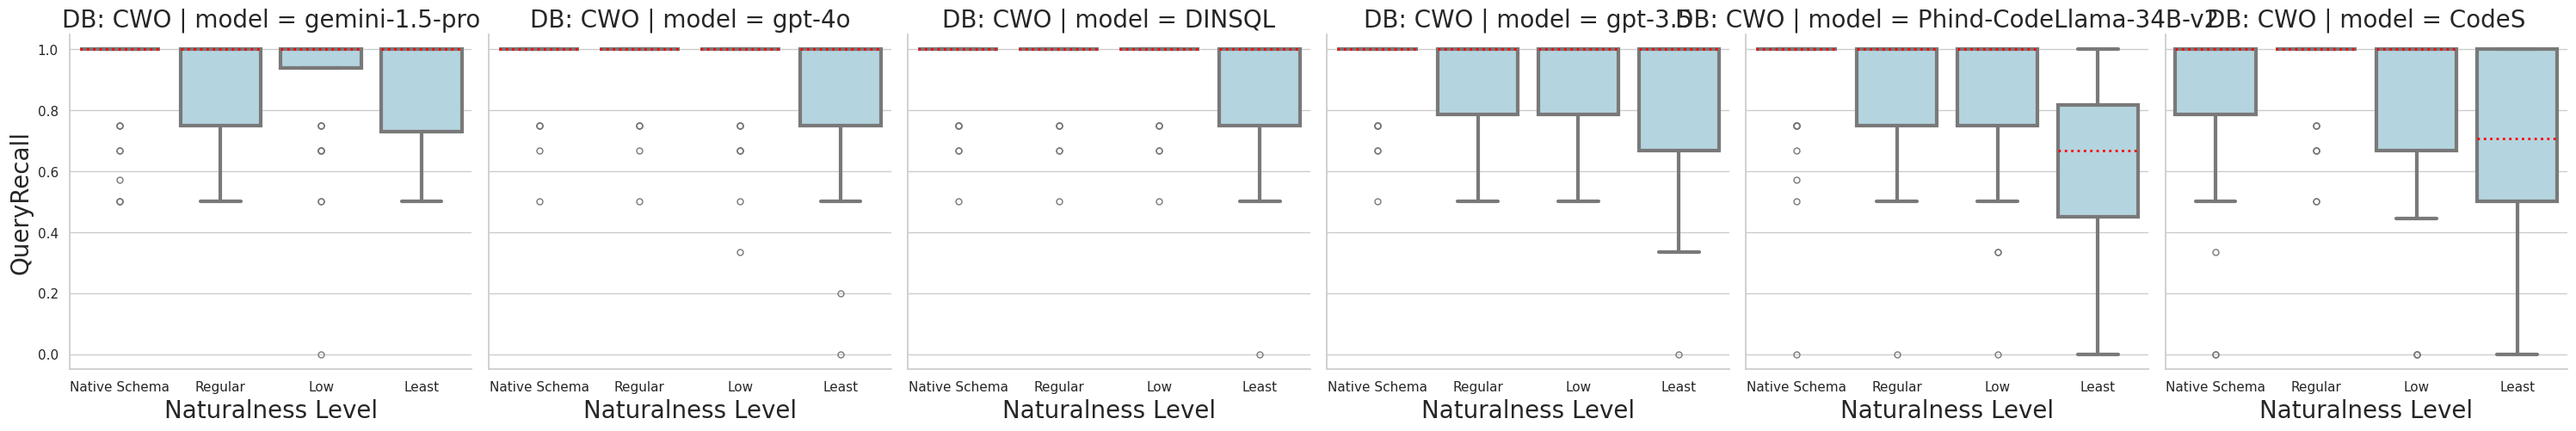

In [46]:
for db_label in annotation_df["Database Label"].unique():
    grid = sns.catplot(
        data=annotation_df.sort_values(
                by=["naturalness_order", "model_order"]
            ).query(
                f"exclude_from_linking == False and `Database Label` == '{db_label}'"
            ),
        x='naturalness_label',
        y='recall',
        col='model',
        row='Database Label',
        kind='box',
        palette=['#ADD8E6'],
        linewidth=3,
        medianprops={'color': 'red', 'ls': 'dotted', 'lw': 2}
        )
    grid.set_axis_labels('Naturalness Level', 'QueryRecall', size=20)
    for ax in grid.axes.flat:
        ax.set_title(ax.get_title().replace("Database Label = ", "DB: "), size=20)
    # grid.set_xticklabels(["Native", "Regular", "Low", "Least", "Regular-Improved"], size=18)
    grid.fig.savefig(f'./figure_output/natlevel-model-recall-boxplot-{db_label}.pdf', dpi=300)


#### Execution Accuracy

##### Execution accuracy bar charts by model

/tmp/ipykernel_38543/3119318953.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=20)
/tmp/ipykernel_38543/3119318953.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=20)


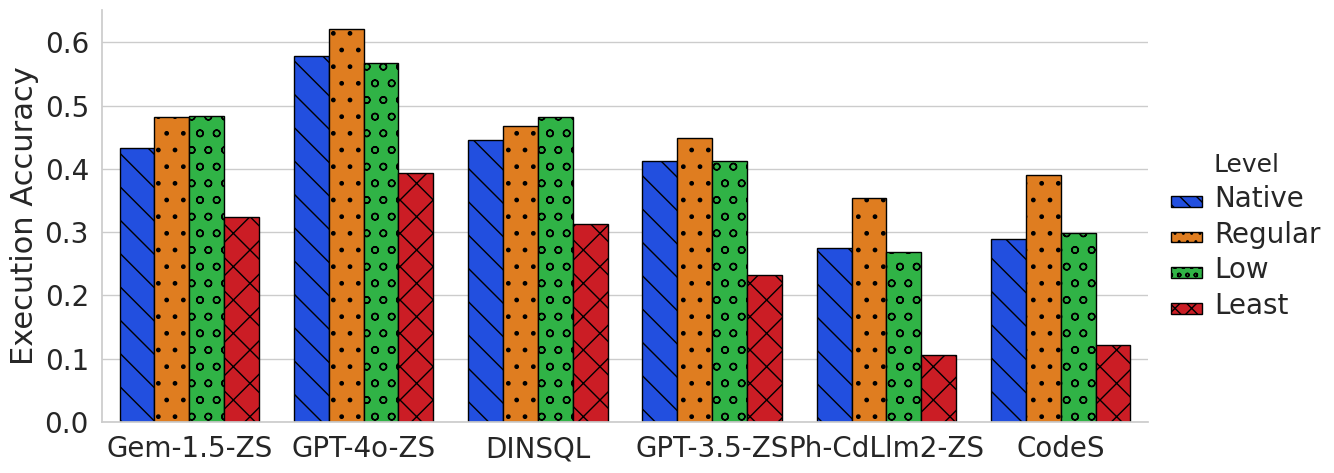

In [47]:
g = sns.catplot(
    data=annotation_df.sort_values(
            by=["naturalness_order", "model_order"]
        ).query(
            "manual_match >= 0"
        ),
    x='model_abbreviated',
    y='manual_match',
    kind='bar',
    # palette=["m", "g", 'b', 'orange'],
    palette='bright',
    hue='naturalness_label',
    legend=True,
    edgecolor="black",
    aspect=2.3,
    errorbar=None
    )
g.set_axis_labels('', 'Execution Accuracy', size=22)
hatches = ['\\', '.', 'o', 'x']

for ax in g.axes.flat:
    ax.tick_params(labelsize=18)
    ax.set_xlabel(ax.get_xlabel(), fontsize=22)
    ax.set_ylabel(ax.get_ylabel(), fontsize=22)
    ax.set_title(ax.get_title(), fontsize=22)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=20)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=20)

for j, f in enumerate(g.axes.flat):
    for i, thisbar in enumerate(f.patches):
        if i < 6:
            thisbar.set_hatch(hatches[0])
        elif i < 12:
            thisbar.set_hatch(hatches[1])
        elif i < 18:
            thisbar.set_hatch(hatches[2])
        else:
            thisbar.set_hatch(hatches[3])
g.legend.set_title('Level', prop={'size': 18})
for t, l in zip(g._legend.texts, ['Native', 'Regular', 'Low', 'Least']):
    t.set_text(l)
    t.set_fontsize(20)
hatches = ['\\\\', '..', 'oo', 'xx']
for legend_entry, hatch in zip(g.legend.get_patches(), hatches):
    legend_entry.set_hatch(hatch)
g.fig.savefig('./figure_output/execution-accuracy-barplot.pdf', dpi=300)

##### Execution Accuracy Table
Note: Need to bold the highest values manually

In [48]:
def perc_agg(x):
    return sum(x) / len(x)

def bold_max_latex(x):
    return "\\textbf{%.2f}" % x

execution_table_df = annotation_df[[
    "model",
    "model_order",
    "Database Label", 
    "db_native_naturalness",
    "naturalness_label", 
    "manual_match",
    "naturalness_order"
    ]].rename(columns={
        "Database Label": "Database",
        "naturalness_label": "Category",
        "model": "Model"
    })
execution_table_df["Category"] = execution_table_df.apply(
    lambda row: row.Category if "Native" not in row.Category else "Native",
    axis=1
)
execution_table_df["Database (Score)"] = execution_table_df.apply(
    lambda row: f"{row.Database} ({row.db_native_naturalness:.2f})",
    axis=1
)
execution_table_df = execution_table_df.rename(columns={
    "db_native_naturalness": "Native Schema Score"
}).pivot_table(
        columns="Database (Score)",
        values="manual_match",
        aggfunc=perc_agg,
        index=["model_order", "Model", "naturalness_order", "Category"]
    ).reset_index(level=2).drop(
        "naturalness_order", 
        axis=1
    ).reset_index(level=0).drop(
        "model_order",
        axis=1
    )
col_format = "p{.9in}p{.5in}"
for i in range(9):
    col_format += "p{.3in}"
execution_table_df.to_latex(
    "./figure_output/execution_accuracy.tex",
    float_format="%.2f",
    column_format=col_format,
    formatters=[bold_max_latex for i in range(11)]
    )
execution_table_df

Database (Score)                 ASIS (0.77)  ATBI (0.70)  CWO (0.84)  \
Model                  Category                                         
gemini-1.5-pro         Native          0.525        0.650       0.600   
                       Regular         0.525        0.625       0.650   
                       Low             0.575        0.625       0.625   
                       Least           0.425        0.325       0.600   
gpt-4o                 Native          0.625        0.725       0.800   
                       Regular         0.650        0.675       0.800   
                       Low             0.550        0.650       0.750   
                       Least           0.275        0.475       0.625   
DINSQL                 Native          0.575        0.550       0.625   
                       Regular         0.500        0.625       0.625   
                       Low             0.625        0.550       0.625   
                       Least           0.250        0.350       0.550   
gpt-3.5                Native          0.625        0.550       0.725   
                       Regular         0.625        0.525       0.650   
                       Low             0.625        0.450       0.700   
                       Least           0.200        0.250       0.500   
Phind-CodeLlama-34B-v2 Native          0.275        0.325       0.625   
                       Regular         0.275        0.450       0.625   
                       Low             0.175        0.275       0.300   
                       Least           0.125        0.125       0.050   
CodeS                  Native          0.425        0.375       0.525   
                       Regular         0.450        0.550       0.575   
                       Low             0.275        0.400       0.300   
                       Least           0.100        0.125       0.225   

Database (Score)                 KIS (0.79)  NPFM (0.70)  NTSB (0.59)  \
Model                  Category                                         
gemini-1.5-pro         Native         0.700        0.725         0.17   
                       Regular        0.425        0.425         0.29   
                       Low            0.775        0.600         0.25   
                       Least          0.625        0.425         0.22   
gpt-4o                 Native         0.800        0.825         0.29   
                       Regular        0.800        0.825         0.39   
                       Low            0.800        0.725         0.29   
                       Least          0.625        0.675         0.28   
DINSQL                 Native         0.525        0.550         0.27   
                       Regular        0.475        0.500         0.28   
                       Low            0.525        0.550         0.29   
                       Least          0.475        0.350         0.27   
gpt-3.5                Native         0.625        0.600         0.13   
                       Regular        0.525        0.600         0.26   
                       Low            0.575        0.600         0.13   
                       Least          0.500        0.350         0.08   
Phind-CodeLlama-34B-v2 Native         0.625        0.400         0.07   
                       Regular        0.600        0.425         0.15   
                       Low            0.525        0.525         0.14   
                       Least          0.300        0.125         0.12   
CodeS                  Native         0.475        0.500         0.11   
                       Regular        0.450        0.675         0.16   
                       Low            0.550        0.625         0.14   
                       Least          0.225        0.325         0.06   

Database (Score)                 NYSED (0.68)  PILB (0.75)  SBOD (0.49)  
Model                  Category                                          
gemini-1.5-pro         Native        0.333333        0